<div class="alert alert-block alert-info">
<b>Projeto III PB</b>
</div>

Este projeto visa construir um modelo de aprendizado de m√°quina para prever a probabilidade de inadimpl√™ncia de clientes em potencial da Home Credit, uma institui√ß√£o financeira que busca ampliar a inclus√£o financeira. Para isso, diversos conjuntos de dados s√£o fornecidos, cada um com informa√ß√µes relevantes sobre os clientes e seus hist√≥ricos de cr√©dito.

Os dados abrangem informa√ß√µes de diferentes n√≠veis, desde dados est√°ticos de cada aplica√ß√£o de empr√©stimo at√© detalhes sobre pagamentos e saldos de cr√©ditos anteriores, tanto na Home Credit quanto em outras institui√ß√µes financeiras.

# Import

In [1]:
# import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import gc

from pathlib import Path
from summarytools import dfSummary
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


import warnings
warnings.filterwarnings("ignore")

In [2]:
# pl.Config.set_tbl_cols(200)
# pl.Config.set_tbl_rows(20)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 70)

# EDA

## Descri√ß√£o dos Arquivos Fornecidos

> **application_{train|test}.csv**
- Arquivos principais, separados em Treinamento (com TARGET) e Teste (sem TARGET).
- Cont√™m dados est√°ticos de cada solicita√ß√£o de empr√©stimo. Cada linha corresponde a um empr√©stimo em nossa base de dados.

> **bureau.csv**
- Re√∫ne todos os cr√©ditos anteriores dos clientes reportados ao Bir√¥ de Cr√©dito (para quem possui empr√©stimo em nossa amostra).
- Para cada empr√©stimo em nossa base, h√° tantas linhas quantos forem os cr√©ditos do cliente informados ao Bir√¥ de Cr√©dito antes da data da solicita√ß√£o.

> **bureau_balance.csv**
- Cont√©m os saldos mensais dos cr√©ditos registrados no Bir√¥ de Cr√©dito.
- Cada linha representa um m√™s de hist√≥rico de um cr√©dito anterior informado ao Bir√¥, ou seja, (# empr√©stimos na base * # cr√©ditos anteriores relevantes * # meses de hist√≥rico dispon√≠vel).

> **POS_CASH_balance.csv**
- Fornece hist√≥ricos mensais de saldos de empr√©stimos POS (ponto de venda) e de empr√©stimos em dinheiro que o cliente teve junto √† Home Credit.
- H√° uma linha para cada m√™s de hist√≥rico de cada cr√©dito anterior na Home Credit (cr√©dito ao consumidor e empr√©stimos em dinheiro) relacionado aos empr√©stimos da amostra. Isso significa (# empr√©stimos na base * # cr√©ditos anteriores relevantes * # meses de hist√≥rico dispon√≠vel).

> **credit_card_balance.csv**
- Re√∫ne hist√≥ricos mensais de saldos de cart√µes de cr√©dito que o cliente possuiu na Home Credit.
- Cada linha representa um m√™s de hist√≥rico de cada cr√©dito anterior (cart√£o de cr√©dito, cr√©dito ao consumidor ou empr√©stimo em dinheiro) relacionado aos empr√©stimos em nossa amostra, no mesmo formato de contagem anterior.

> **previous_application.csv**
- Lista todas as solicita√ß√µes anteriores de empr√©stimo na Home Credit para clientes presentes em nossa amostra.
- Cada linha equivale a uma aplica√ß√£o anterior associada aos empr√©stimos analisados.

> **installments_payments.csv**
- Traz o registro de todos os pagamentos de cr√©ditos anteriores na Home Credit relacionados √† nossa amostra.
- Cada linha corresponde a um pagamento efetuado ou em atraso. Ou seja, cada pagamento de presta√ß√£o ou parcela n√£o paga referente a um cr√©dito anterior tamb√©m faz parte do conjunto.

> **HomeCredit_columns_description.csv**
- Descreve cada coluna dos diferentes arquivos de dados, fornecendo informa√ß√µes adicionais sobre o significado e formato dos campos.

<h2> Database Schema </h2>

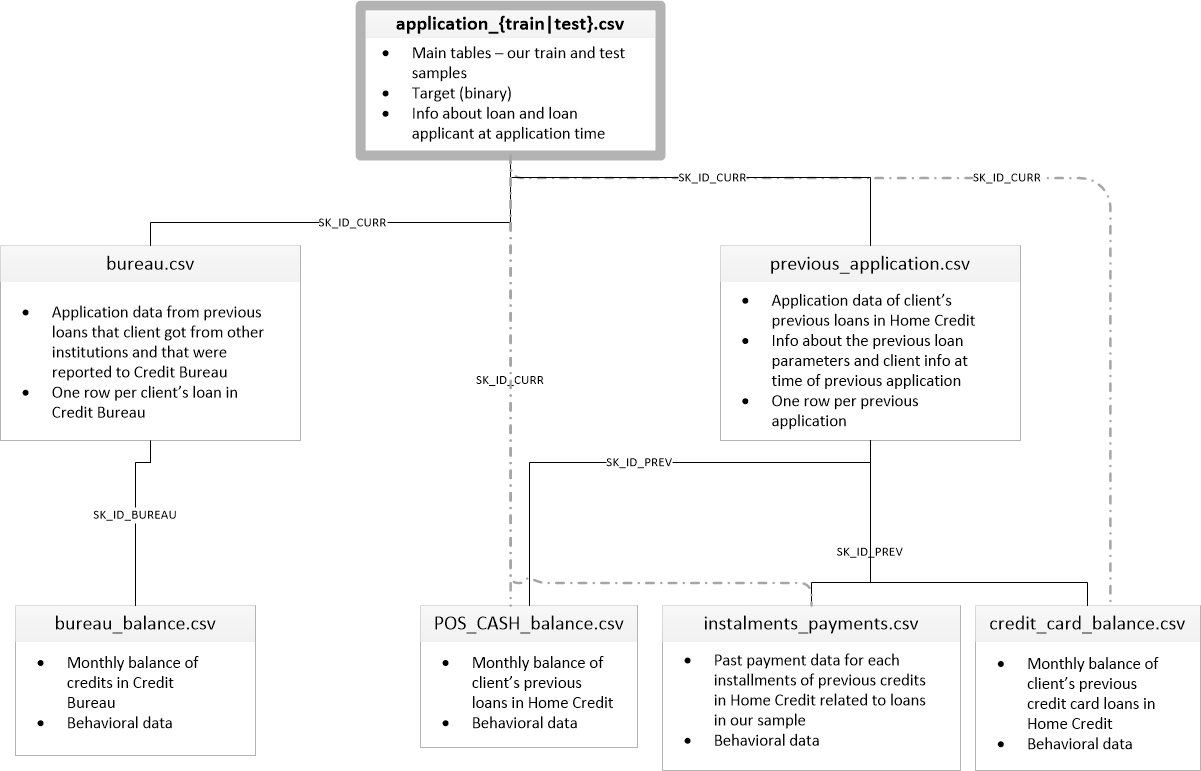

## Primeiros Registros

In [3]:
def reduce_memory_usage(df: pd.DataFrame, convert_obj_to_cat: bool = True, convert_dates: bool = True, use_unsigned: bool = True) -> pd.DataFrame:
    """
    Otimiza o uso de mem√≥ria em um DataFrame realizando downcasting de colunas num√©ricas
    e, opcionalmente, convertendo colunas de texto para 'category' e colunas de datas para 
    datetime64. As convers√µes s√£o feitas diretamente no DataFrame de entrada.

    Par√¢metros
    ----------
    df : pd.DataFrame
        DataFrame a ser otimizado.
    convert_obj_to_cat : bool, opcional, default True
        Se True, colunas do tipo object s√£o analisadas e convertidas para 'category'
        caso tenham alta repeti√ß√£o de valores (baixa cardinalidade).
    convert_dates : bool, opcional, default True
        Se True, tenta converter colunas reconhecidas como datas/hor√°rios para datetime64.
    use_unsigned : bool, opcional, default True
        Se True, utiliza tipos unsigned (uint8, uint16, etc.) para colunas sem valores negativos.

    Retorna
    -------
    pd.DataFrame
        O pr√≥prio DataFrame de entrada, por√©m com tipos de colunas otimizados.

    Observa√ß√µes
    ----------
    1. Se houver colunas com valores ausentes (NaN) que sejam do tipo num√©rico,
       a convers√£o para tipo inteiro pode falhar ou ser for√ßada para float. 
       Caso deseje manter comportamento de 'inteiro com NA', considere o uso dos
       tipos 'Int8', 'Int16', etc. do pandas (com 'I' mai√∫sculo).
    2. Colunas convertidas para 'category' podem perder a ordem de strings
       (se houver necessidade de uso posterior de ordenamento alfanum√©rico).
    3. Se as colunas j√° tiverem algum tipo de convers√£o posterior planejada
       (por exemplo, encoding espec√≠fico), avalie se a convers√£o para 'category'
       √© desejada neste momento.
    """

    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Mem√≥ria usada antes da redu√ß√£o: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        # 1. Tentativa de convers√£o para datetime
        if convert_dates and col_type == object:
            try:
                df[col] = pd.to_datetime(df[col], errors='raise')
                continue  # Se converteu para datetime, pula para a pr√≥xima coluna
            except (ValueError, TypeError):
                pass

        # 2. Convers√£o para category se for texto e estiver habilitado
        if col_type == object and convert_obj_to_cat:
            num_unique_values = df[col].nunique(dropna=False)
            num_total_values = len(df[col])
            # Exemplo de heur√≠stica simples: se menos de 50% dos valores s√£o √∫nicos convertemos para 'category'
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
            continue

        # 3. Downcasting de colunas num√©ricas
        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            # Verifica se h√° valores ausentes, pois pode impedir convers√£o p/ int
            has_na = df[col].isnull().any()

            # Tentativa de uso de inteiros ou floats
            if pd.api.types.is_integer_dtype(df[col]) and not has_na:
                # Decidir entre signed/unsigned
                if use_unsigned and c_min >= 0:
                    if c_max <= np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max <= np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max <= np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)
            else:
                # Downcast de float (ou int com NA) para float16, float32 ou float64
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Mem√≥ria usada ap√≥s otimiza√ß√£o: {end_mem:.2f} MB")
    print(f"Redu√ß√£o de {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df

In [4]:
# Carregando os Dados (Com Otimiza√ß√£o de Mem√≥ria)

# df_train = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "application_train.csv")))
# print("-+-" * 10)
# df_bureau_balance = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "bureau_balance.csv")))
# print("-+-" * 10)
# df_bureau = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "bureau.csv")))
# print("-+-" * 10)
# df_credit_card = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "credit_card_balance.csv")))
# print("-+-" * 10)
# df_installments_payments = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "installments_payments.csv")))
# print("-+-" * 10)
# df_pos_cash_balance = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "POS_CASH_balance.csv")))
# print("-+-" * 10)
# df_previous_application = reduce_memory_usage(pd.read_csv(Path("..", "data", "01_raw", "previous_application.csv")))

In [ ]:
df_train = pd.read_csv(Path("data", "01_raw", "application_train.csv"))
df_bureau_balance = pd.read_csv(Path("data", "01_raw", "bureau_balance.csv"))
df_bureau = pd.read_csv(Path("data", "01_raw", "bureau.csv"))
df_installments_payments = pd.read_csv(Path("data", "01_raw", "installments_payments.csv"))

# df_credit_card = pd.read_csv(Path("data", "01_raw", "credit_card_balance.csv"))
# df_pos_cash_balance = pd.read_csv(Path("data", "01_raw", "POS_CASH_balance.csv"))
# df_previous_application = pd.read_csv(Path("data", "01_raw", "previous_application.csv"))

### df_train

In [6]:
print(df_train.shape)
df_train.head()

(307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [7]:
df_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

**An√°lise:** 

Foi identificado que a maior parte das vari√°veis apresenta valores nulos. Em rela√ß√£o ao tipo de dado, elas j√° est√£o alinhadas ao dicion√°rio de dados, com exce√ß√£o de **`DAYS_BIRTH`**, **`DAYS_EMPLOYED`**, **`DAYS_REGISTRATION`**, **`DAYS_ID_PUBLISH`** e **`DAYS_LAST_PHONE_CHANGE`**, que apresentam valores negativos e demandam transforma√ß√£o em valores absolutos. Tendo isso em vista, vamos dar prioridade ao tratamento de valores ausentes em um primeiro momento.

#### Valores Ausentes

In [8]:
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Gera um sum√°rio de valores ausentes (NaNs) em cada coluna de um DataFrame.

    Par√¢metros
    ----------
    df : pd.DataFrame
        DataFrame a ser analisado.

    Retorno
    -------
    pd.DataFrame
        DataFrame contendo a contagem e o percentual de valores ausentes
        para cada coluna que apresente ao menos um valor ausente, ordenado
        do maior para o menor percentual de ausentes.

    Observa√ß√µes
    -----------
    - √â exibido na tela um resumo informando o n√∫mero de colunas com valores ausentes.
    - Somente as colunas que apresentam valores ausentes s√£o retornadas na tabela.
    """

    # N√∫mero total de linhas do DataFrame
    nrows = len(df)

    # Contagem de valores ausentes por coluna
    mis_val = df.isnull().sum()

    # Percentual de valores ausentes
    mis_val_percent = 100 * mis_val / nrows

    # Concatenando as duas informa√ß√µes em um √∫nico DataFrame
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Renomeando as colunas
    mis_val_table.columns = ['Valores Ausentes', '% dos Valores Totais']

    # Filtrando apenas colunas com valores ausentes e ordenando
    mis_val_table = (
        mis_val_table[mis_val_table['% dos Valores Totais'] != 0]
        .sort_values('% dos Valores Totais', ascending=False)
        .round(1)
    )

    # Exibindo um resumo
    print(
        f"O dataframe selecionado tem {df.shape[1]} colunas.\n"
        f"Existem {mis_val_table.shape[0]} colunas com valores ausentes."
    )

    return mis_val_table

In [9]:
# An√°lise de Percentual dos valores Ausentes
valores_ausentes_train_df = missing_values_table(df_train)
valores_ausentes_train_df = valores_ausentes_train_df[valores_ausentes_train_df["% dos Valores Totais"] >= 40]
valores_ausentes_train_df

O dataframe selecionado tem 122 colunas.
Existem 67 colunas com valores ausentes.


Valores Ausentes  % dos Valores Totais
COMMONAREA_MEDI                         214865                  69.9
COMMONAREA_AVG                          214865                  69.9
COMMONAREA_MODE                         214865                  69.9
NONLIVINGAPARTMENTS_MEDI                213514                  69.4
NONLIVINGAPARTMENTS_MODE                213514                  69.4
NONLIVINGAPARTMENTS_AVG                 213514                  69.4
FONDKAPREMONT_MODE                      210295                  68.4
LIVINGAPARTMENTS_MODE                   210199                  68.4
LIVINGAPARTMENTS_MEDI                   210199                  68.4
LIVINGAPARTMENTS_AVG                    210199                  68.4
FLOORSMIN_MODE                          208642                  67.8
FLOORSMIN_MEDI                          208642                  67.8
FLOORSMIN_AVG                           208642                  67.8
YEARS_BUILD_MODE                        204488                  66.5
YEARS_BUILD_MEDI                        204488                  66.5
YEARS_BUILD_AVG                         204488                  66.5
OWN_CAR_AGE                             202929                  66.0
LANDAREA_AVG                            182590                  59.4
LANDAREA_MEDI                           182590                  59.4
LANDAREA_MODE                           182590                  59.4
BASEMENTAREA_MEDI                       179943                  58.5
BASEMENTAREA_AVG                        179943                  58.5
BASEMENTAREA_MODE                       179943                  58.5
EXT_SOURCE_1                            173378                  56.4
NONLIVINGAREA_MEDI                      169682                  55.2
NONLIVINGAREA_MODE                      169682                  55.2
NONLIVINGAREA_AVG                       169682                  55.2
ELEVATORS_MEDI                          163891                  53.3
ELEVATORS_MODE                          163891                  53.3
ELEVATORS_AVG                           163891                  53.3
WALLSMATERIAL_MODE                      156341                  50.8
APARTMENTS_MODE                         156061                  50.7
APARTMENTS_MEDI                         156061                  50.7
APARTMENTS_AVG                          156061                  50.7
ENTRANCES_MODE                          154828                  50.3
ENTRANCES_AVG                           154828                  50.3
ENTRANCES_MEDI                          154828                  50.3
LIVINGAREA_MEDI                         154350                  50.2
LIVINGAREA_MODE                         154350                  50.2
LIVINGAREA_AVG                          154350                  50.2
HOUSETYPE_MODE                          154297                  50.2
FLOORSMAX_MEDI                          153020                  49.8
FLOORSMAX_AVG                           153020                  49.8
FLOORSMAX_MODE                          153020                  49.8
YEARS_BEGINEXPLUATATION_AVG             150007                  48.8
YEARS_BEGINEXPLUATATION_MEDI            150007                  48.8
YEARS_BEGINEXPLUATATION_MODE            150007                  48.8
TOTALAREA_MODE                          148431                  48.3
EMERGENCYSTATE_MODE                     145755                  47.4

In [10]:
num_missing = len(valores_ausentes_train_df)
total_columns = len(df_train.columns)
perc_missing = num_missing / total_columns * 100

print(f"{num_missing} colunas possuem valores ausentes de um total de {total_columns} colunas, representando aproximadamente {perc_missing:.2f}%")

49 colunas possuem valores ausentes de um total de 122 colunas, representando aproximadamente 40.16%


In [11]:
# Exclua a coluna de identifica√ß√£o prim√°ria para checagem de duplicatas
cols_without_pk = [col for col in df_train.columns if col != 'SK_ID_CURR']

# Identifica as linhas duplicadas com base nas colunas selecionadas
duplicated_rows = df_train[df_train.duplicated(subset=cols_without_pk, keep='first')]

# Exibe a quantidade e os primeiros registros duplicados
print(f"Quantidade de duplicadas (exceto 'SK_ID_CURR'): {len(duplicated_rows)}")
print(duplicated_rows.head())

Quantidade de duplicadas (exceto 'SK_ID_CURR'): 0
Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AV

In [12]:
# Check IDs duplicados
duplicate_ids = df_train['SK_ID_CURR'][df_train['SK_ID_CURR'].duplicated(keep=False)]
duplicates_counts = duplicate_ids.value_counts()
print(duplicates_counts)

Series([], Name: count, dtype: int64)


**Resultado da An√°lise**: N√£o existem colunas duplicadas e os IDs tamb√©m n√£o consta duplica√ß√£o.

#### An√°lise com Symarytools

In [13]:
summary_train = dfSummary(df_train)
summary_train

### df_bureau_balance & df_bureau

In [14]:
print(df_bureau_balance.shape)
df_bureau_balance.head()

(27299925, 3)


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [15]:
df_bureau_balance.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   SK_ID_BUREAU    27299925 non-null  int64 
 1   MONTHS_BALANCE  27299925 non-null  int64 
 2   STATUS          27299925 non-null  object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [16]:
print(df_bureau.shape)
df_bureau.head()

(1716428, 17)


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [17]:
df_bureau.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_CURR              1716428 non-null  int64  
 1   SK_ID_BUREAU            1716428 non-null  int64  
 2   CREDIT_ACTIVE           1716428 non-null  object 
 3   CREDIT_CURRENCY         1716428 non-null  object 
 4   DAYS_CREDIT             1716428 non-null  int64  
 5   CREDIT_DAY_OVERDUE      1716428 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     1610875 non-null  float64
 7   DAYS_ENDDATE_FACT       1082775 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  591940 non-null   float64
 9   CNT_CREDIT_PROLONG      1716428 non-null  int64  
 10  AMT_CREDIT_SUM          1716415 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     1458759 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    1124648 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  1716428 non-null  float64
 14  CR

**Resultado:**

No conjunto de dados do bureau, constatamos que a maioria das vari√°veis apresenta poucos valores ausentes, em contraste com o dataset de solicita√ß√µes, que possui diversas lacunas. Algumas vari√°veis importantes ‚Äì por exemplo, **`AMT_ANNUITY`**, **`DAYS_CREDIT_ENDDATE`** e **`AMT_CREDIT_MAX_OVERDUE`** ‚Äì podem ter muitos dados faltantes; contudo, essa aus√™ncia pode indicar que os clientes n√£o tiveram problemas significativos de cr√©dito anteriormente.

Al√©m disso, vale ressaltar que o saldo do bureau (bureau_balance) n√£o apresenta valores ausentes e os tipos de dados est√£o em conformidade com o dicion√°rio fornecido.

#### Valores Ausentes

In [18]:
# An√°lise de Percentual dos valores Ausentes
valores_ausentes_bureau = missing_values_table(df_bureau)
valores_ausentes_bureau = valores_ausentes_bureau[valores_ausentes_bureau["% dos Valores Totais"] >= 40]
valores_ausentes_bureau

O dataframe selecionado tem 17 colunas.
Existem 7 colunas com valores ausentes.


Valores Ausentes  % dos Valores Totais
AMT_ANNUITY                      1226791                  71.5
AMT_CREDIT_MAX_OVERDUE           1124488                  65.5

In [19]:
num_missing = len(valores_ausentes_bureau)
total_columns = len(df_bureau.columns)
perc_missing = num_missing / total_columns * 100

print(f"{num_missing} colunas possuem valores ausentes de um total de {total_columns} colunas, representando aproximadamente {perc_missing:.2f}%")

2 colunas possuem valores ausentes de um total de 17 colunas, representando aproximadamente 11.76%


Para cada coluna, √© fundamental avaliar n√£o s√≥ a quantidade de dados ausentes, mas tamb√©m a sua relev√¢ncia para o desempenho do modelo. Quando uma coluna apresenta um percentual elevado de valores faltantes, aplicar t√©cnicas de imputa√ß√£o pode resultar em dados pouco confi√°veis ou at√© enviesados.

Assim, √© importante identificar essas colunas por exemplo, aquelas com mais de 40% ou 50% de aus√™ncias para decidir se vale a pena imput√°-las ou se √© melhor descart√°-las do conjunto de vari√°veis.

Esse processo garante que o modelo seja treinado com dados de qualidade e que os esfor√ßos de tratamento estejam direcionados para colunas com maior potencial informativo.

> **An√°lise de Valores Ausentes em Dados de Cr√©dito**

A seguir, analisamos algumas vari√°veis do conjunto de dados relacionadas a cr√©ditos, destacando a quantidade de valores n√£o nulos e a poss√≠vel interpreta√ß√£o dos dados ausentes.

---

> 1. DAYS_CREDIT_ENDDATE (1.610.875 valores n√£o nulos de 1.716.428)

* **Poss√≠vel Mecanismo de Aus√™ncia:** MNAR (Missing Not At Random) ou MAR (Missing At Random)
* **Interpreta√ß√£o:**  
    - **MNAR:** A aus√™ncia do valor pode indicar que o cr√©dito ainda est√° ativo, e a data de t√©rmino prevista n√£o foi definida.
    - **MAR:** Os dados podem ter sido omitidos aleatoriamente durante a coleta, sem rela√ß√£o direta com o valor em si.

---

> 2. DAYS_ENDDATE_FACT (1.082.775 valores n√£o nulos)

* **Poss√≠vel Mecanismo de Aus√™ncia:** MNAR  
* **Interpreta√ß√£o:**  
    - A vari√°vel registra a data final real do cr√©dito. A aus√™ncia deste valor sugere que o empr√©stimo ainda est√° em aberto, estando diretamente relacionada ao status do cr√©dito.

---

> 3. AMT_CREDIT_MAX_OVERDUE (591.940 valores n√£o nulos)

* **Poss√≠vel Mecanismo de Aus√™ncia:** MNAR  
* **Interpreta√ß√£o:**  
    - Representa o valor m√°ximo de atraso registrado. A falta de registro pode indicar que o cliente nunca teve atraso significativo no pagamento, sugerindo que a aus√™ncia est√° relacionada √† performance do pagamento.

---

> 4. AMT_CREDIT_SUM (1.716.415 valores n√£o nulos)

* **Poss√≠vel Mecanismo de Aus√™ncia:** MAR ou MCAR (Missing Completely At Random)  
* **Interpreta√ß√£o:**  
    - Geralmente √© esperado que o total do cr√©dito seja informado. Se faltar, pode ser fruto de erros de entrada ou omiss√£o acidental, sendo menos prov√°vel que esteja relacionado a uma caracter√≠stica do pr√≥prio cliente (MCAR) ou esteja dependente de outros fatores observados (MAR).

---

> 5. AMT_CREDIT_SUM_DEBT (1.458.759 valores n√£o nulos)

* **Poss√≠vel Mecanismo de Aus√™ncia:** MNAR  
* **Interpreta√ß√£o:**  
    - Indica o montante da d√≠vida remanescente. Em casos de cr√©dito totalmente quitado, a aus√™ncia ou valor zero pode ser esperada, refletindo uma depend√™ncia direta do status de pagamento do empr√©stimo.

---

> 6. AMT_CREDIT_SUM_LIMIT (1.124.648 valores n√£o nulos)

* **Poss√≠vel Mecanismo de Aus√™ncia:** MNAR  
* **Interpreta√ß√£o:**  
    - Registra o limite do cr√©dito. Sua aus√™ncia pode ocorrer em produtos financeiros que n√£o definem um limite fixo, evidenciando caracter√≠sticas espec√≠ficas do produto.

---

> 7. AMT_ANNUITY (489.637 valores n√£o nulos)

* **Poss√≠vel Mecanismo de Aus√™ncia:** MNAR  
* **Interpreta√ß√£o:**  
    - Trata dos valores das anuidades. A aus√™ncia deste dado pode indicar que o empr√©stimo n√£o possui um calend√°rio de pagamentos com anuidade (por exemplo, quando o pagamento √© √∫nico), estando fortemente ligada √† modalidade do cr√©dito.

---

**Resumo dos Mecanismos de Dados Faltantes:**

- **MCAR (Missing Completely At Random):**  
    - A aus√™ncia dos dados ocorre aleatoriamente, sem rela√ß√£o com outras vari√°veis.  
    - *Exemplo:* Ocasionalmente, um dado pode estar faltando por erro de digita√ß√£o ou omiss√£o acidental.

- **MAR (Missing At Random):**  
    - A falta dos valores est√° relacionada a outras caracter√≠sticas observ√°veis, embora n√£o ao pr√≥prio valor ausente.  
    - *Exemplo:* Clientes com renda mais alta podem ter maior probabilidade de n√£o informar determinados detalhes por quest√µes de confidencialidade, mas isso pode ser correlacionado a outras vari√°veis coletadas.

- **MNAR (Missing Not At Random):**  
    - A aus√™ncia est√° diretamente relacionada ao valor que falta, podendo indicar um comportamento ou status subjacente do cliente.  
    - *Exemplo:* Clientes com hist√≥rico de atraso prolongado podem ter dados ausentes justamente por n√£o terem apresentado um valor de atraso definido.

#### An√°lise com Symarytools

In [20]:
summary_bureau_balance = dfSummary(df_bureau_balance)
summary_bureau_balance

#### Pr√©-Processamento df_bureau_balance & df_bureau

In [21]:
def convert_credit_status_to_numeric_code(status: str) -> int:
    """
    Converte o status de cr√©dito em um c√≥digo num√©rico.

    Par√¢metros:
    -----------
    status : str
        Status do cr√©dito. Exemplo: 'Closed', 'Active', etc.

    Retorna:
    --------
    int
        C√≥digo num√©rico onde:
          - 0 representa 'Closed'
          - 1 representa 'Active'
          - 2 para quaisquer outros status.
    """
    if status == 'Closed':
        return 0
    elif status == 'Active':
        return 1
    else:
        return 2

In [22]:
def processing_data_bureau_dfs(bureau_data: pd.DataFrame) -> pd.DataFrame:
    """
    Processa e transforma os dados do dataset 'bureau_data'.

    As opera√ß√µes realizadas s√£o:
      - Preenchimento de valores nulos com zero para colunas espec√≠ficas;
      - Cria√ß√£o de novas colunas a partir de c√°lculos envolvendo datas e montantes;
      - Agrega√ß√£o de informa√ß√µes por cliente (SK_ID_CURR) e realiza√ß√£o de merges para 
        incorporar dados agregados ao DataFrame original;
      - Convers√£o do status de cr√©dito em c√≥digo num√©rico e c√°lculo da m√©dia desse c√≥digo por cliente;
      - C√°lculo da soma total de cr√©dito e d√≠vida, e a raz√£o entre eles para cada cliente.

    Par√¢metros:
    -----------
    bureau_data : pd.DataFrame
        DataFrame que cont√©m os dados do bureau.

    Retorna:
    --------
    pd.DataFrame
        DataFrame transformado com novas colunas agregadas.
    """
    # Preenche valores nulos com 0 para as colunas selecionadas
    colunas_preencher = [
        'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
        'DAYS_CREDIT_UPDATE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY'
    ]
    for col in colunas_preencher:
        bureau_data[col] = bureau_data[col].fillna(0)
    
    # Cria novas colunas baseadas em c√°lculos
    bureau_data['DURACAO_CREDITO'] = -bureau_data['DAYS_CREDIT'] + bureau_data['DAYS_CREDIT_ENDDATE']
    bureau_data['DIFERENCA_DATA_FIM'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_ENDDATE_FACT']
    bureau_data['DIFERENCA_ATUALIZACAO'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_CREDIT_UPDATE']
    bureau_data['PERCENTUAL_DIVIDA'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_CREDIT_SUM_DEBT'].replace(0, np.nan)
    bureau_data['DIFERENCA_CREDITO_DIVIDA'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['RAZAO_CREDITO_ANUIDADE'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_ANNUITY'].replace(0, np.nan)
    bureau_data['RAZAO_DIVIDA_ANUIDADE'] = bureau_data['AMT_CREDIT_SUM_DEBT'] / bureau_data['AMT_ANNUITY'].replace(0, np.nan)
    # Caso a coluna 'AMT_CREDIT_SUM_OVERDUE' n√£o exista, utiliza 0 como valor padr√£o
    bureau_data['DIFERENCA_CREDITO_ATRASO'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data.get('AMT_CREDIT_SUM_OVERDUE', 0)

    # Agrega a quantidade de empr√©stimos por cliente
    emprestimos = bureau_data.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()\
                              .reset_index().rename(columns={'SK_ID_BUREAU': 'QTD_EMPRESTIMOS_CLIENTE'})
    bureau_data = bureau_data.merge(emprestimos, on='SK_ID_CURR', how='left')
    
    # Agrega o n√∫mero de tipos de cr√©dito distintos por cliente
    tipos = bureau_data.groupby('SK_ID_CURR')['CREDIT_TYPE'].nunique()\
                       .reset_index().rename(columns={'CREDIT_TYPE': 'TIPOS_CREDITO_CLIENTE'})
    bureau_data = bureau_data.merge(tipos, on='SK_ID_CURR', how='left')
    bureau_data['MEDIA_TIPO_EMPRESTIMO'] = bureau_data['QTD_EMPRESTIMOS_CLIENTE'] / bureau_data['TIPOS_CREDITO_CLIENTE']
    
    # Converte o status de cr√©dito para c√≥digo num√©rico e calcula a m√©dia por cliente
    bureau_data['CODIGO_TIPO_CREDITO'] = bureau_data['CREDIT_ACTIVE'].apply(convert_credit_status_to_numeric_code)
    media_codigo = bureau_data.groupby('SK_ID_CURR')['CODIGO_TIPO_CREDITO'].mean()\
                              .reset_index().rename(columns={'CODIGO_TIPO_CREDITO': 'MEDIA_CODIGO_CREDITO_CLIENTE'})
    bureau_data = bureau_data.merge(media_codigo, on='SK_ID_CURR', how='left')
    
    # Agrega soma total de cr√©dito e de d√≠vida por cliente, e calcula a raz√£o entre ambos
    soma_credito = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()\
                              .reset_index().rename(columns={'AMT_CREDIT_SUM': 'SOMA_TOTAL_CREDITO'})
    bureau_data = bureau_data.merge(soma_credito, on='SK_ID_CURR', how='left')
    
    soma_divida = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()\
                             .reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT': 'SOMA_TOTAL_DIVIDA'})
    bureau_data = bureau_data.merge(soma_divida, on='SK_ID_CURR', how='left')
    bureau_data['RAZAO_CREDITO_DIVIDA'] = bureau_data['SOMA_TOTAL_CREDITO'] / bureau_data['SOMA_TOTAL_DIVIDA'].replace(0, np.nan)

    return bureau_data

In [23]:
def one_hot_encoder(df: pd.DataFrame, categorical_columns: list = None, nan_as_category: bool = True, drop_first: bool = False) -> (pd.DataFrame, list): # type: ignore
    """
    Realiza a codifica√ß√£o one-hot das colunas categ√≥ricas de um DataFrame.

    Se 'categorical_columns' n√£o for especificada, todas as colunas do tipo 'object' ou 'category'
    ser√£o utilizadas para a codifica√ß√£o. O par√¢metro 'nan_as_category' permite que valores ausentes sejam
    tratados como uma categoria separada, e 'drop_first' evita a cria√ß√£o de multicolinearidade ao descartar
    a primeira categoria de cada coluna.

    Par√¢metros:
    -----------
    df : pd.DataFrame
        O DataFrame a ser transformado.
    categorical_columns : list, opcional
        Lista de colunas categ√≥ricas a serem codificadas. Caso None, utiliza todas as colunas categ√≥ricas.
    nan_as_category : bool, opcional
        Se True, os valores NaN ser√£o considerados uma categoria separada.
    drop_first : bool, opcional
        Se True, remove a primeira categoria de cada coluna (√∫til para evitar multicolinearidade).

    Retorna:
    --------
    tuple
        - DataFrame transformado com as colunas one-hot encoded.
        - Lista de novas colunas criadas pela codifica√ß√£o.
    """
    original_columns = df.columns.tolist()
    if not categorical_columns:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    df_transformed = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, drop_first=drop_first)
    new_columns = [col for col in df_transformed.columns if col not in original_columns]
    return df_transformed, new_columns

In [24]:
# Processar a fun√ß√£o
bureau_clean = processing_data_bureau_dfs(df_bureau)

In [25]:
# One Hot Encoding the Bureau Datasets
bureau_encode, bureau_data_columns = one_hot_encoder(bureau_clean, nan_as_category=False)
bureau_balance_encode, bureau_balance_columns = one_hot_encoder(df_bureau_balance, nan_as_category=False)

In [26]:
bureau_encode.head()

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0      215354       5714462         -497                   0   
1      215354       5714463         -208                   0   
2      215354       5714464         -203                   0   
3      215354       5714465         -203                   0   
4      215354       5714466         -629                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0               -153.0             -153.0                     NaN   
1               1075.0                0.0                     NaN   
2                528.0                0.0                     NaN   
3                  0.0                0.0                     NaN   
4               1197.0                0.0                 77674.5   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                   0         91323.0                  0.0   
1                   0        225000.0             171342.0   
2                   0        464323.5                  0.0   
3                   0         90000.0                  0.0   
4                   0       2700000.0                  0.0   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
0                   NaN                     0.0                -131   
1                   NaN                     0.0                 -20   
2                   NaN                     0.0                 -16   
3                   NaN                     0.0                 -16   
4                   NaN                     0.0                 -21   

   AMT_ANNUITY  DURACAO_CREDITO  DIFERENCA_DATA_FIM  DIFERENCA_ATUALIZACAO  \
0          0.0            344.0                 0.0                  -22.0   
1          0.0           1283.0              1075.0                 1095.0   
2          0.0            731.0               528.0                  544.0   
3          0.0            203.0                 0.0                   16.0   
4          0.0           1826.0              1197.0                 1218.0   

   PERCENTUAL_DIVIDA  DIFERENCA_CREDITO_DIVIDA  RAZAO_CREDITO_ANUIDADE  \
0                NaN                   91323.0                     NaN   
1           1.313163                   53658.0                     NaN   
2                NaN                  464323.5                     NaN   
3                NaN                   90000.0                     NaN   
4                NaN                 2700000.0                     NaN   

   RAZAO_DIVIDA_ANUIDADE  DIFERENCA_CREDITO_ATRASO  QTD_EMPRESTIMOS_CLIENTE  \
0                    NaN                   91323.0                       11   
1                    NaN                  225000.0                       11   
2                    NaN                  464323.5                       11   
3                    NaN                   90000.0                       11   
4                    NaN                 2700000.0                       11   

   TIPOS_CREDITO_CLIENTE  MEDIA_TIPO_EMPRESTIMO  CODIGO_TIPO_CREDITO  \
0                      3               3.666667                    0   
1                      3               3.666667                    1   
2                      3               3.666667                    1   
3                      3               3.666667                    1   
4                      3               3.666667                    1   

   MEDIA_CODIGO_CREDITO_CLIENTE  SOMA_TOTAL_CREDITO  SOMA_TOTAL_DIVIDA  \
0                      0.545455           5973945.3          284463.18   
1                      0.545455           5973945.3          284463.18   
2                      0.545455           5973945.3          284463.18   
3                      0.545455           5973945.3          284463.18   
4                      0.545455           5973945.3          284463.18   

   RAZAO_CREDITO_DIVIDA  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  \
0             21.000768                 False                  

In [27]:
# Chegando a fun√ß√£o, buscando um ID
checagem1 = bureau_encode[bureau_encode['SK_ID_CURR'] == 215354]
checagem1.head(15)

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0           215354       5714462         -497                   0   
1           215354       5714463         -208                   0   
2           215354       5714464         -203                   0   
3           215354       5714465         -203                   0   
4           215354       5714466         -629                   0   
5           215354       5714467         -273                   0   
6           215354       5714468          -43                   0   
225157      215354       5714458        -1872                   0   
225158      215354       5714459        -1734                   0   
225159      215354       5714460        -1333                   0   
225160      215354       5714461        -1011                   0   

        DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0                    -153.0             -153.0                     NaN   
1                    1075.0                0.0                     NaN   
2                     528.0                0.0                     NaN   
3                       0.0                0.0                     NaN   
4                    1197.0                0.0                 77674.5   
5                   27460.0                0.0                     0.0   
6                      79.0                0.0                     0.0   
225157               -776.0            -1203.0                     NaN   
225158               -638.0            -1336.0                     NaN   
225159              -1089.0             -987.0                     NaN   
225160               -830.0             -770.0                     NaN   

        CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                        0         91323.0                 0.00   
1                        0        225000.0            171342.00   
2                        0        464323.5                 0.00   
3                        0         90000.0                 0.00   
4                        0       2700000.0                 0.00   
5                        0        180000.0             71017.38   
6                        0         42103.8             42103.80   
225157                   0        494550.0                 0.00   
225158                   0       1084032.0                 0.00   
225159                   0        102150.0                 0.00   
225160                   0        500463.0                 0.00   

        AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
0                        NaN                     0.0                -131   
1                        NaN                     0.0                 -20   
2                        NaN                     0.0                 -16   
3                        NaN                     0.0                 -16   
4                        NaN                     0.0                 -21   
5                  108982.62                     0.0                 -31   
6                       0.00                     0.0                 -22   
225157                  0.00                     0.0                -696   
225158                   NaN                     0.0               -1336   
225159                   NaN                     0.0                -984   
225160                   NaN                     0.0                -767   

        AMT_ANNUITY  DURACAO_CREDITO  DIFERENCA_DATA_FIM  \
0               0.0            344.0                 0.0   
1               0.0           1283.0              1075.0   
2               0.0            731.0               528.0   
3               0.0            203.0                 0.0   
4               0.0           1826.0              1197.0   
5               0.0          27733.0             27460.0   
6               0.0            122.0                79.0   
225157          0.0           1096.0               427.0   
225158          0.0           10

In [28]:
def processing_data_bureau_dfs_2nd(bureau_data: pd.DataFrame, bureau_balance: pd.DataFrame, bureau_data_columns: list, bureau_balance_columns: list) -> pd.DataFrame:
    """
    Processa e agrega dados dos dataframes 'bureau_data' e 'bureau_balance' para facilitar 
    an√°lises preditivas.

    As opera√ß√µes realizadas s√£o:
      - Agrega√ß√£o dos dados hist√≥ricos (bureau_balance) por 'SK_ID_BUREAU' utilizando m√∫ltiplas 
        estat√≠sticas para a coluna 'MONTHS_BALANCE' e para cada coluna listada em bureau_balance_columns.
      - Mescla dos dados agregados com o dataframe 'bureau_data' e remo√ß√£o da coluna de chave.
      - Libera√ß√£o de mem√≥ria ap√≥s a mesclagem.
      - Agrega√ß√£o final de dados (num√©ricos e categ√≥ricos) em 'bureau_data_balance' agrupando por 'SK_ID_CURR',
        onde as estat√≠sticas s√£o definidas separadamente para colunas num√©ricas e aquelas provenientes 
        de bureau_balance (com sufixo '_MEAN').
      - Renomeia as colunas do dataframe final com o prefixo 'BUREAU_' para indicar a origem dos dados.

    Par√¢metros:
      bureau_data (pd.DataFrame): DataFrame com os dados originais do bureau.
      bureau_balance (pd.DataFrame): DataFrame com os hist√≥ricos mensais do bureau.
      bureau_data_columns (list): Lista de colunas de bureau_data que dever√£o ser agregadas de forma categ√≥rica.
      bureau_balance_columns (list): Lista de colunas de bureau_balance (al√©m de 'MONTHS_BALANCE') a agregar.

    Retorna:
      pd.DataFrame: DataFrame com as novas m√©tricas agregadas, agrupado por 'SK_ID_CURR'.
    """

    # Define as estat√≠sticas de agrega√ß√£o para o dataframe bureau_balance
    balance_aggs = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size', 'var']}
    # Para cada coluna adicional, adiciona tamb√©m a soma
    for col in bureau_balance_columns:
        balance_aggs[col] = ['min', 'max', 'mean', 'size', 'var', 'sum']

    # Agrega os dados de bureau_balance por 'SK_ID_BUREAU'
    bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(balance_aggs)
    # Renomeia as colunas no padr√£o: COLUNA_AGG (tudo em mai√∫sculas para a opera√ß√£o)
    bureau_balance_agg.columns = [f"{col[0]}_{col[1].upper()}" for col in bureau_balance_agg.columns.tolist()]

    # Mescla os dados agregados com bureau_data usando 'SK_ID_BUREAU'
    data_merged = bureau_data.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')
    data_merged.drop('SK_ID_BUREAU', axis=1, inplace=True)

    # Libera a mem√≥ria utilizada
    del bureau_balance_agg
    gc.collect()

    # Define as agrega√ß√µes para as colunas num√©ricas do dataframe mesclado
    numerical_agg = {
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
        'DAYS_CREDIT': ['mean', 'var'],
        'DAYS_CREDIT_UPDATE': ['mean', 'min'],
        'CREDIT_DAY_OVERDUE': ['mean', 'min'],
        'DAYS_CREDIT_ENDDATE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM': ['mean', 'sum', 'max'],
        'DURACAO_CREDITO': ['mean', 'max', 'min'],
        'DIFERENCA_DATA_FIM': ['mean', 'max', 'min'],
        'DIFERENCA_ATUALIZACAO': ['mean'],
        'PERCENTUAL_DIVIDA': ['mean', 'max', 'min'],
        'DIFERENCA_CREDITO_DIVIDA': ['mean'],
        'RAZAO_CREDITO_ANUIDADE': ['mean', 'max'],
        'RAZAO_DIVIDA_ANUIDADE': ['mean'],
        'DIFERENCA_CREDITO_ATRASO': ['mean'],
        'MEDIA_TIPO_EMPRESTIMO': ['mean'],
        'MEDIA_CODIGO_CREDITO_CLIENTE': ['mean']
    }

    # Cria agrega√ß√µes para as colunas categ√≥ricas (ou num√©ricas agreg√°veis) de bureau_data
    categorical_agg = {col: ['mean', 'sum'] for col in bureau_data_columns}
    # Adiciona tamb√©m as agrega√ß√µes para os valores m√©dios provenientes do bureau_balance
    for col in bureau_balance_columns:
        categorical_agg[f"{col}_MEAN"] = ['mean', 'sum']

    # Agrega os dados mesclados por 'SK_ID_CURR'
    aggregated_data = data_merged.groupby('SK_ID_CURR').agg({**numerical_agg, **categorical_agg})
    # Renomeia as colunas com o prefixo 'BUREAU_'
    aggregated_data.columns = [f"BUREAU_{col[0]}_{col[1].upper()}" for col in aggregated_data.columns.tolist()]
    aggregated_data.reset_index(inplace=True)

    return aggregated_data

In [29]:
# Aplicando a fun√ß√£o
bureau_balance_final = processing_data_bureau_dfs_2nd(bureau_encode, bureau_balance_encode,bureau_data_columns, bureau_balance_columns)

In [30]:
bureau_balance_final.head()

SK_ID_CURR  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  \
0      100001                     85240.928571   
1      100002                     30722.625000   
2      100003                         0.000000   
3      100004                         0.000000   
4      100005                    189469.500000   

   BUREAU_AMT_CREDIT_SUM_DEBT_SUM  BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN  \
0                        596686.5                                 0.0   
1                        245781.0                                 0.0   
2                             0.0                                 0.0   
3                             0.0                                 0.0   
4                        568408.5                                 0.0   

   BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM  BUREAU_DAYS_CREDIT_MEAN  \
0                                0.0              -735.000000   
1                                0.0              -874.000000   
2                                0.0             -1400.750000   
3                                0.0              -867.000000   
4                                0.0              -190.666667   

   BUREAU_DAYS_CREDIT_VAR  BUREAU_DAYS_CREDIT_UPDATE_MEAN  \
0           240043.666667                      -93.142857   
1           186150.000000                     -499.875000   
2           827783.583333                     -816.000000   
3           421362.000000                     -532.000000   
4            26340.333333                      -54.333333   

   BUREAU_DAYS_CREDIT_UPDATE_MIN  BUREAU_CREDIT_DAY_OVERDUE_MEAN  \
0                           -155                             0.0   
1                          -1185                             0.0   
2                          -2131                             0.0   
3                           -682                             0.0   
4                           -121                             0.0   

   BUREAU_CREDIT_DAY_OVERDUE_MIN  BUREAU_DAYS_CREDIT_ENDDATE_MEAN  \
0                              0                        82.428571   
1                              0                      -261.750000   
2                              0                      -544.500000   
3                              0                      -488.500000   
4                              0                       439.333333   

   BUREAU_CNT_CREDIT_PROLONG_SUM  BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN  \
0                              0                           0.00000   
1                              0                        7997.14125   
2                              0                      202500.00000   
3                              0                           0.00000   
4                              0                           0.00000   

   BUREAU_AMT_CREDIT_SUM_LIMIT_SUM  BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN  \
0                            0.000                                 NaN   
1                        31988.565                            1681.029   
2                       810000.000                               0.000   
3                            0.000                               0.000   
4                            0.000                               0.000   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX  BUREAU_AMT_ANNUITY_MAX  \
0                                NaN                 10822.5   
1                           5043.645                     0.0   
2                              0.000                     0.0   
3                              0.000                     0.0   
4                              0.000                  4261.5   

   BUREAU_AMT_ANNUITY_MEAN  BUREAU_AMT_ANNUITY_SUM  \
0              3545.357143                 24817.5   
1                 0.000000                     0.0   
2                 0.000000                     0.0   
3                 0.000000                     0.0   
4              1420.500000                  4261.5   

   BUREAU_AMT_CREDIT_SUM_MEAN  BUREAU_AMT_CREDIT_SUM_SUM  \
0               207623.571429                

In [31]:
# Chegando a fun√ß√£o, buscando um ID (novamente...)
checagem2 = bureau_balance_final[bureau_balance_final['SK_ID_CURR'] == 215354]
checagem2.head(15)

SK_ID_CURR  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  \
99120      215354                     25860.289091   

       BUREAU_AMT_CREDIT_SUM_DEBT_SUM  BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN  \
99120                       284463.18                                 0.0   

       BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM  BUREAU_DAYS_CREDIT_MEAN  \
99120                                0.0              -727.818182   

       BUREAU_DAYS_CREDIT_VAR  BUREAU_DAYS_CREDIT_UPDATE_MEAN  \
99120           432794.763636                     -367.272727   

       BUREAU_DAYS_CREDIT_UPDATE_MIN  BUREAU_CREDIT_DAY_OVERDUE_MEAN  \
99120                          -1336                             0.0   

       BUREAU_CREDIT_DAY_OVERDUE_MIN  BUREAU_DAYS_CREDIT_ENDDATE_MEAN  \
99120                              0                      2441.181818   

       BUREAU_CNT_CREDIT_PROLONG_SUM  BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN  \
99120                              0                          36327.54   

       BUREAU_AMT_CREDIT_SUM_LIMIT_SUM  BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN  \
99120                        108982.62                             25891.5   

       BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX  BUREAU_AMT_ANNUITY_MAX  \
99120                            77674.5                     0.0   

       BUREAU_AMT_ANNUITY_MEAN  BUREAU_AMT_ANNUITY_SUM  \
99120                      0.0                     0.0   

       BUREAU_AMT_CREDIT_SUM_MEAN  BUREAU_AMT_CREDIT_SUM_SUM  \
99120               543085.936364                  5973945.3   

       BUREAU_AMT_CREDIT_SUM_MAX  BUREAU_DURACAO_CREDITO_MEAN  \
99120                  2700000.0                       3169.0   

       BUREAU_DURACAO_CREDITO_MAX  BUREAU_DURACAO_CREDITO_MIN  \
99120                     27733.0                       122.0   

       BUREAU_DIFERENCA_DATA_FIM_MEAN  BUREAU_DIFERENCA_DATA_FIM_MAX  \
99120                     2845.636364                        27460.0   

       BUREAU_DIFERENCA_DATA_FIM_MIN  BUREAU_DIFERENCA_ATUALIZACAO_MEAN  \
99120                         -102.0                        2808.454545   

       BUREAU_PERCENTUAL_DIVIDA_MEAN  BUREAU_PERCENTUAL_DIVIDA_MAX  \
99120                       1.615918                      2.534591   

       BUREAU_PERCENTUAL_DIVIDA_MIN  BUREAU_DIFERENCA_CREDITO_DIVIDA_MEAN  \
99120                           1.0                         517225.647273   

       BUREAU_RAZAO_CREDITO_ANUIDADE_MEAN  BUREAU_RAZAO_CREDITO_ANUIDADE_MAX  \
99120                                 NaN                                NaN   

       BUREAU_RAZAO_DIVIDA_ANUIDADE_MEAN  \
99120                                NaN   

       BUREAU_DIFERENCA_CREDITO_ATRASO_MEAN  \
99120                         543085.936364   

       BUREAU_MEDIA_TIPO_EMPRESTIMO_MEAN  \
99120                           3.666667   

       BUREAU_MEDIA_CODIGO_CREDITO_CLIENTE_MEAN  \
99120                                  0.545455   

       BUREAU_CREDIT_ACTIVE_Active_MEAN  BUREAU_CREDIT_ACTIVE_Active_SUM  \
99120                          0.545455                                6   

       BUREAU_CREDIT_ACTIVE_Bad debt_MEAN  BUREAU_CREDIT_ACTIVE_Bad debt_SUM  \
99120                                 0.0                                  0   

       BUREAU_CREDIT_ACTIVE_Closed_MEAN  BUREAU_CREDIT_ACTIVE_Closed_SUM  \
99120                          0.454545                                5   

       BUREAU_CREDIT_ACTIVE_Sold_MEAN  BUREAU_CREDIT_ACTIVE_Sold_SUM  \
99120                             0.0                              0   

       BUREAU_CREDIT_CURRENCY_currency 1_MEAN  \
99120                                     1.0   

       BUREAU_CREDIT_CURRENCY_currency 1_SUM  \
99120                                     11   

       BUREAU_CREDIT_CURRENCY_currency 2_MEAN  \
99120                                     0.0   

       BUREAU_CREDIT_CURRENCY_currency 2_SUM  \
99120                                      0   

       BUREAU_CREDIT_CURRENCY_currency 3_MEAN  \
99120                                     0.0   

In [32]:
bureau_balance_final.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 102 columns):
 #    Column                                                                Non-Null Count   Dtype  
---   ------                                                                --------------   -----  
 0    SK_ID_CURR                                                            305811 non-null  int64  
 1    BUREAU_AMT_CREDIT_SUM_DEBT_MEAN                                       305811 non-null  float64
 2    BUREAU_AMT_CREDIT_SUM_DEBT_SUM                                        305811 non-null  float64
 3    BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN                                    305811 non-null  float64
 4    BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM                                     305811 non-null  float64
 5    BUREAU_DAYS_CREDIT_MEAN                                               305811 non-null  float64
 6    BUREAU_DAYS_CREDIT_VAR                                                2642

### df_installments_payments

In [33]:
print(df_installments_payments.shape)
df_installments_payments.head()

(13605401, 8)


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [34]:
df_installments_payments.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   SK_ID_PREV              13605401 non-null  int64  
 1   SK_ID_CURR              13605401 non-null  int64  
 2   NUM_INSTALMENT_VERSION  13605401 non-null  float64
 3   NUM_INSTALMENT_NUMBER   13605401 non-null  int64  
 4   DAYS_INSTALMENT         13605401 non-null  float64
 5   DAYS_ENTRY_PAYMENT      13602496 non-null  float64
 6   AMT_INSTALMENT          13605401 non-null  float64
 7   AMT_PAYMENT             13602496 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


#### Valores Ausentes

In [35]:
# An√°lise de Percentual dos valores Ausentes
valores_ausentes_installments = missing_values_table(df_installments_payments)
valores_ausentes_installments = valores_ausentes_installments[valores_ausentes_installments["% dos Valores Totais"] >= 40]
valores_ausentes_installments

O dataframe selecionado tem 8 colunas.
Existem 2 colunas com valores ausentes.


Empty DataFrame
Columns: [Valores Ausentes, % dos Valores Totais]
Index: []

In [36]:
num_missing = len(valores_ausentes_installments)
total_columns = len(df_installments_payments.columns)
perc_missing = num_missing / total_columns * 100

print(f"{num_missing} colunas possuem valores ausentes de um total de {total_columns} colunas, representando aproximadamente {perc_missing:.2f}%")

0 colunas possuem valores ausentes de um total de 8 colunas, representando aproximadamente 0.00%


#### An√°lise com Sumarytools

In [37]:
summary_installments = dfSummary(df_installments_payments)
summary_installments

In [38]:
df_installments_payments = df_installments_payments.drop_duplicates()

#### Pr√©-Processamento df_installments_payments

In [39]:
def processar_pagamentos_parcelas(installments_payments):
    """
    Processa e agrega os dados de pagamentos de parcelas para extra√ß√£o de novas features.

    A fun√ß√£o agrupa os pagamentos por 'SK_ID_PREV' e 'NUM_INSTALMENT_NUMBER', calcula novas
    vari√°veis como a diferen√ßa entre o valor da parcela e o valor efetivamente pago, raz√£o de
    pagamento, valor pago a mais e indicadores de atraso. Em seguida, realiza a codifica√ß√£o
    One-Hot nas colunas categ√≥ricas e agrega os dados num√©ricos por cliente (SK_ID_CURR).

    Par√¢metros:
        installments_payments (pd.DataFrame): DataFrame contendo dados de pagamentos de parcelas.
    
    Retorna:
        pd.DataFrame: DataFrame agregado com vari√°veis derivadas dos pagamentos, indexado por 'SK_ID_CURR'.
    """
    # Verifica se a coluna SK_ID_CURR existe
    if 'SK_ID_CURR' not in installments_payments.columns:
        raise KeyError("A coluna 'SK_ID_CURR' n√£o est√° presente no DataFrame 'installments_payments'.")

    # Agrupa o valor pago por parcela (chave composta de SK_ID_PREV e NUM_INSTALMENT_NUMBER)
    pagamentos_agrupados = (
        installments_payments.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT']
        .sum()
        .reset_index()
        .rename(columns={'AMT_PAYMENT': 'VALOR_PAGO_AGRUPADO'})
    )

    # Mescla os dados originais com os valores agregados dos pagamentos
    pagamentos_final = installments_payments.merge(
        pagamentos_agrupados,
        on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'],
        how='left'
    )
    
    # Calcula novas features de pagamento
    pagamentos_final['DIFERENCA_PAGAMENTO'] = pagamentos_final['AMT_INSTALMENT'] - pagamentos_final['VALOR_PAGO_AGRUPADO']
    pagamentos_final['RAZAO_PAGAMENTO'] = pagamentos_final['AMT_INSTALMENT'] / pagamentos_final['VALOR_PAGO_AGRUPADO']
    pagamentos_final['VALOR_PAGO_A_MAIS'] = pagamentos_final['AMT_PAYMENT'] - pagamentos_final['AMT_INSTALMENT']
    pagamentos_final['PAGAMENTO_EXTRA'] = (pagamentos_final['VALOR_PAGO_A_MAIS'] > 0).astype(int)
    
    # Calcula os dias de atraso utilizando opera√ß√µes vetorizadas
    try:
        # Diferen√ßa entre o dia de entrada e o dia da parcela; garante que o valor m√≠nimo seja 0
        pagamentos_final['DIAS_ATRASO'] = (pagamentos_final['DAYS_ENTRY_PAYMENT'] - pagamentos_final['DAYS_INSTALMENT']).clip(lower=0)
        
        # Indicador se houve pagamento com atraso e raz√£o de atraso
        pagamentos_final['PAGAMENTO_ATRASADO'] = (pagamentos_final['DIAS_ATRASO'] > 0).astype(int)
        pagamentos_final['RAZAO_PAGAMENTO_PARCELA'] = pagamentos_final['AMT_PAYMENT'] / pagamentos_final['AMT_INSTALMENT']
        pagamentos_final['RAZAO_ATRASO'] = np.where(
            pagamentos_final['PAGAMENTO_ATRASADO'] == 1,
            pagamentos_final['RAZAO_PAGAMENTO_PARCELA'],
            0
        )
        # Indicador de atraso significativo (quando a raz√£o de atraso √© superior a 0.05)
        pagamentos_final['ATRASO_SIGNIFICATIVO'] = (pagamentos_final['RAZAO_ATRASO'] > 0.05).astype(int)
        
        # Cria colunas indicadoras para diferentes limiares de atraso
        for dias in [7, 15, 30, 60, 90, 180, 720]:
            pagamentos_final[f'DIAS_ATRASO_{dias}'] = (pagamentos_final['DIAS_ATRASO'] >= dias).astype(int)
    except KeyError:
        pagamentos_final['DIAS_ATRASO'] = np.nan

    # Aplica One-Hot Encoding nas colunas categ√≥ricas (a fun√ß√£o one_hot_encoder deve estar previamente definida)
    pagamentos_final, pay_final_columns = one_hot_encoder(pagamentos_final, nan_as_category=False)

    # Define as agrega√ß√µes num√©ricas a serem calculadas para cada vari√°vel
    numeric_agg_payments = {
        'PAGAMENTO_ATRASADO': ['mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'NUM_INSTALMENT_NUMBER': ['max'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'DIFERENCA_PAGAMENTO': ['max', 'mean', 'min', 'sum'],
        'VALOR_PAGO_A_MAIS': ['max', 'mean', 'min'],
        'DIAS_ATRASO': ['max', 'mean', 'sum']
    }
    # Inclui as colunas resultantes do One-Hot Encoding na agrega√ß√£o (calculando a m√©dia)
    for col in pay_final_columns:
        numeric_agg_payments[col] = ['mean']

    # Agrega os dados por cliente (SK_ID_CURR)
    pagamentos_final_agg = pagamentos_final.groupby('SK_ID_CURR').agg(numeric_agg_payments)
    
    # Renomeia as colunas agregadas com o prefixo 'INS_'
    pagamentos_final_agg.columns = [
        f"INS_{col[0]}_{col[1].upper()}" for col in pagamentos_final_agg.columns.tolist()
    ]
    
    # Acrescenta uma coluna com a quantidade de parcelas por cliente
    pagamentos_final_agg['QTD_PARCELAS'] = pagamentos_final.groupby('SK_ID_CURR').size()
    
    # Libera mem√≥ria removendo o DataFrame intermedi√°rio
    del pagamentos_final
    gc.collect()

    pagamentos_final_agg.reset_index(inplace=True)
    return pagamentos_final_agg

In [40]:
# Aplicando a fun√ß√£o
installments_clean = processar_pagamentos_parcelas(df_installments_payments)
installments_clean.shape

(339587, 22)

In [41]:
installments_clean.head()

SK_ID_CURR  INS_PAGAMENTO_ATRASADO_MEAN  INS_PAGAMENTO_ATRASADO_SUM  \
0      100001                     0.142857                           1   
1      100002                     0.000000                           0   
2      100003                     0.000000                           0   
3      100004                     0.000000                           0   
4      100005                     0.111111                           1   

   INS_AMT_PAYMENT_MIN  INS_AMT_PAYMENT_MAX  INS_AMT_PAYMENT_MEAN  \
0             3951.000            17397.900           5885.132143   
1             9251.775            53093.745          11559.247105   
2             6662.970           560835.360          64754.586000   
3             5357.250            10573.965           7096.155000   
4             4813.200            17656.245           6240.205000   

   INS_AMT_PAYMENT_SUM  INS_NUM_INSTALMENT_NUMBER_MAX  INS_AMT_INSTALMENT_MAX  \
0            41195.925                              4               17397.900   
1           219625.695                             19               53093.745   
2          1618864.650                             12              560835.360   
3            21288.465                              3               10573.965   
4            56161.845                              9               17656.245   

   INS_AMT_INSTALMENT_MEAN  INS_AMT_INSTALMENT_SUM  \
0              5885.132143               41195.925   
1             11559.247105              219625.695   
2             64754.586000             1618864.650   
3              7096.155000               21288.465   
4              6240.205000               56161.845   

   INS_DIFERENCA_PAGAMENTO_MAX  INS_DIFERENCA_PAGAMENTO_MEAN  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   INS_DIFERENCA_PAGAMENTO_MIN  INS_DIFERENCA_PAGAMENTO_SUM  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   INS_VALOR_PAGO_A_MAIS_MAX  INS_VALOR_PAGO_A_MAIS_MEAN  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   INS_VALOR_PAGO_A_MAIS_MIN  INS_DIAS_ATRASO_MAX  INS_DIAS_ATRASO_MEAN  \
0                        0.0                 11.0              1.571429   
1                        0.0                  0.0              0.000000   
2                        0.0                  0.0              0.000000   
3                        0.0                  0.0              0.000000   
4                        0.0                  1.0              0.111111   

   INS_DIAS_ATRASO_SUM  QTD_PARCELAS  
0                 11.0             7  
1                  0.0            19  
2                  0.0            25  
3                  0.0             3  
4                  1.0             9

In [42]:
installments_clean['INS_DIAS_ATRASO_SUM'].describe()

count    339587.000000
mean         41.417275
std         326.815463
min           0.000000
25%           0.000000
50%           1.000000
75%          20.000000
max       82957.000000
Name: INS_DIAS_ATRASO_SUM, dtype: float64

In [43]:
installments_clean.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339587 entries, 0 to 339586
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   SK_ID_CURR                     339587 non-null  int64  
 1   INS_PAGAMENTO_ATRASADO_MEAN    339587 non-null  float64
 2   INS_PAGAMENTO_ATRASADO_SUM     339587 non-null  int32  
 3   INS_AMT_PAYMENT_MIN            339578 non-null  float64
 4   INS_AMT_PAYMENT_MAX            339578 non-null  float64
 5   INS_AMT_PAYMENT_MEAN           339578 non-null  float64
 6   INS_AMT_PAYMENT_SUM            339587 non-null  float64
 7   INS_NUM_INSTALMENT_NUMBER_MAX  339587 non-null  int64  
 8   INS_AMT_INSTALMENT_MAX         339587 non-null  float64
 9   INS_AMT_INSTALMENT_MEAN        339587 non-null  float64
 10  INS_AMT_INSTALMENT_SUM         339587 non-null  float64
 11  INS_DIFERENCA_PAGAMENTO_MAX    339587 non-null  float64
 12  INS_DIFERENCA_PAGAMENTO_MEAN  

> **Etapa de Pr√©-processamento de Dados**

>> Objetivo
A etapa de pr√©-processamento de dados visa transformar os dados brutos em um formato adequado para a an√°lise e constru√ß√£o de modelos preditivos. Nesta fase, aplicamos diversas t√©cnicas para garantir que os dados estejam limpos, consistentes e relevantes para o problema em quest√£o.

> Import√¢ncia

1. **Qualidade dos Dados:**
    - **Tratamento de Valores Ausentes:** Preencher ou remover valores ausentes para evitar problemas durante a modelagem.
    - **Consist√™ncia dos Dados:** Assegurar que os tipos de dados estejam de acordo com o dicion√°rio de dados e realizar transforma√ß√µes necess√°rias, como converter valores negativos em valores absolutos.

2. **Engenharia de Features:**
    - **Cria√ß√£o de Novas Vari√°veis:** Gerar novas vari√°veis que possam capturar informa√ß√µes relevantes, como a dura√ß√£o do cr√©dito, diferen√ßas de datas, e raz√£o entre valores.
    - **Codifica√ß√£o de Vari√°veis Categ√≥ricas:** Transformar vari√°veis categ√≥ricas em num√©ricas usando t√©cnicas como One-Hot Encoding, para que possam ser utilizadas nos modelos de machine learning.

3. **Agrega√ß√£o de Dados:**
    - **Agrega√ß√£o por Cliente:** Consolidar informa√ß√µes de diferentes fontes para cada cliente, criando vari√°veis que resumem o comportamento do cliente em rela√ß√£o a cr√©ditos e pagamentos de parcelas.

> Aplica√ß√£o na An√°lise Inicial
Aplicamos essas t√©cnicas de pr√©-processamento para garantir que nossos dados estejam preparados para as etapas subsequentes de an√°lise e modelagem. A limpeza e transforma√ß√£o inicial dos dados nos permite identificar e corrigir poss√≠veis inconsist√™ncias e lacunas, al√©m de criar um conjunto de dados robusto e informativo. Ao fazer isso, aumentamos a qualidade dos nossos modelos preditivos e melhoramos a capacidade de generaliza√ß√£o dos mesmos para novos dados.

> Integra√ß√£o com Conjuntos de Dados de Treinamento e Teste
Realizamos essa etapa de pr√©-processamento para que, posteriormente, possamos realizar a fus√£o dos dados processados com os conjuntos de dados de treinamento e teste. Isso garante que todas as transforma√ß√µes aplicadas aos dados brutos sejam refletidas de forma consistente em ambos os conjuntos, evitando vazamento de dados e assegurando que o modelo seja treinado e avaliado de maneira justa.

> Resumo das T√©cnicas Utilizadas

- **Tratamento de Valores Nulos:** Preenchimento de valores nulos com m√©dia, mediana, ou moda.
- **Transforma√ß√£o de Dados:** Convers√£o de valores negativos em valores absolutos para vari√°veis temporais.
- **Cria√ß√£o de Novas Features:** Gera√ß√£o de vari√°veis como diferen√ßa de pagamento, dias de atraso, e outras m√©tricas financeiras.
- **Codifica√ß√£o One-Hot:** Transforma√ß√£o de vari√°veis categ√≥ricas em um formato num√©rico adequado.
- **Agrega√ß√£o de Dados:** Consolida√ß√£o de informa√ß√µes por cliente para criar um conjunto de dados unificado e informativo.

Estas t√©cnicas asseguram que nosso conjunto de dados est√° pronto para as pr√≥ximas etapas de an√°lise e modelagem, proporcionando uma base s√≥lida para a constru√ß√£o de modelos preditivos precisos e eficientes.


## Merge DataFrames

In [44]:
train_merged = df_train.merge(bureau_balance_final, on='SK_ID_CURR', how='left')
train_merged = train_merged.merge(installments_clean, on='SK_ID_CURR', how='left')

In [45]:
train_merged.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [46]:
# reduce_memory_usage(train_merged)

In [47]:
train_merged.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 244 columns):
 #    Column                                                                Non-Null Count   Dtype  
---   ------                                                                --------------   -----  
 0    SK_ID_CURR                                                            307511 non-null  int64  
 1    TARGET                                                                307511 non-null  int64  
 2    NAME_CONTRACT_TYPE                                                    307511 non-null  object 
 3    CODE_GENDER                                                           307511 non-null  object 
 4    FLAG_OWN_CAR                                                          307511 non-null  object 
 5    FLAG_OWN_REALTY                                                       307511 non-null  object 
 6    CNT_CHILDREN                                                          3075

## An√°lise train_merged

In [48]:
train_merged.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

### Valores Ausentes

In [49]:
# An√°lise de Percentual dos valores Ausentes
valores_ausentes_df_train = missing_values_table(train_merged)
valores_ausentes_df_train = valores_ausentes_df_train[valores_ausentes_df_train["% dos Valores Totais"] >= 40]
valores_ausentes_df_train

O dataframe selecionado tem 244 colunas.
Existem 189 colunas com valores ausentes.


Valores Ausentes  % dos Valores Totais
BUREAU_RAZAO_CREDITO_ANUIDADE_MAX             247239                  80.4
BUREAU_RAZAO_DIVIDA_ANUIDADE_MEAN             247239                  80.4
BUREAU_RAZAO_CREDITO_ANUIDADE_MEAN            247239                  80.4
BUREAU_STATUS_0_MEAN_MEAN                     215280                  70.0
BUREAU_STATUS_X_MEAN_MEAN                     215280                  70.0
BUREAU_STATUS_1_MEAN_MEAN                     215280                  70.0
BUREAU_STATUS_2_MEAN_MEAN                     215280                  70.0
BUREAU_STATUS_3_MEAN_MEAN                     215280                  70.0
BUREAU_STATUS_C_MEAN_MEAN                     215280                  70.0
BUREAU_STATUS_4_MEAN_MEAN                     215280                  70.0
BUREAU_STATUS_5_MEAN_MEAN                     215280                  70.0
COMMONAREA_AVG                                214865                  69.9
COMMONAREA_MODE                               214865                  69.9
COMMONAREA_MEDI                               214865                  69.9
NONLIVINGAPARTMENTS_AVG                       213514                  69.4
NONLIVINGAPARTMENTS_MODE                      213514                  69.4
NONLIVINGAPARTMENTS_MEDI                      213514                  69.4
FONDKAPREMONT_MODE                            210295                  68.4
LIVINGAPARTMENTS_MODE                         210199                  68.4
LIVINGAPARTMENTS_AVG                          210199                  68.4
LIVINGAPARTMENTS_MEDI                         210199                  68.4
FLOORSMIN_AVG                                 208642                  67.8
FLOORSMIN_MODE                                208642                  67.8
FLOORSMIN_MEDI                                208642                  67.8
YEARS_BUILD_AVG                               204488                  66.5
YEARS_BUILD_MODE                              204488                  66.5
YEARS_BUILD_MEDI                              204488                  66.5
OWN_CAR_AGE                                   202929                  66.0
LANDAREA_MODE                                 182590                  59.4
LANDAREA_AVG                                  182590                  59.4
LANDAREA_MEDI                                 182590                  59.4
BASEMENTAREA_MEDI                             179943                  58.5
BASEMENTAREA_MODE                             179943                  58.5
BASEMENTAREA_AVG                              179943                  58.5
EXT_SOURCE_1                                  173378                  56.4
NONLIVINGAREA_MEDI                            169682                  55.2
NONLIVINGAREA_AVG                             169682                  55.2
NONLIVINGAREA_MODE                            169682                  55.2
ELEVATORS_AVG                                 163891                  53.3
ELEVATORS_MEDI                                163891                  53.3
ELEVATORS_MODE                                163891                  53.3
WALLSMATERIAL_MODE                            156341                  50.8
APARTMENTS_MEDI                               156061                  50.7
APARTMENTS_AVG                                156061                  50.7
APARTMENTS_MODE                               156061                  50.7
ENTRANCES_MEDI                                154828                  50.3
ENTRANCES_AVG                                 154828                  50.3
ENTRANCES_MODE                                154828                  50.3
LIVINGAREA_AVG                                154350                  50.2
LIVINGAREA_MODE                               154350                  50.2
LIVINGAREA_MEDI                               154350                  50.2
HOUSETYPE_MODE                                154297                  50.2
FLOORSMAX_AVG                                 153020         

### Duplica√ß√µes

In [50]:
# An√°lise de valores duplicados

duplicated_rows = train_merged.duplicated().sum()
print(f"N√∫mero de linhas duplicadas: {duplicated_rows}")

N√∫mero de linhas duplicadas: 0


### √öltimos Tratamentos

In [51]:
df_train_clean_final = train_merged.copy()

In [52]:
suffixes_remover = ["_MEDI", "_MODE"]

# Identifica colunas que terminam com esses sufixos
cols_to_drop = [col for col in df_train_clean_final.columns if col.endswith(tuple(suffixes_remover))]

# Remove essas colunas
df_train_clean_final.drop(columns=cols_to_drop, inplace=True)

In [53]:
df_train_clean_final.shape

(307511, 211)

In [54]:
def remove_high_missing_columns(df: pd.DataFrame, threshold: float = 0.4) -> pd.DataFrame:
    """
    Remove colunas de um DataFrame que apresentam porcentagem de valores ausentes
    (NaN) superior a um limite definido.

    Par√¢metros
    ----------
    df : pd.DataFrame
        DataFrame a ser processado.
    threshold : float, opcional, default = 0.4
        Limite de porcentagem de valores ausentes para remover a coluna.
        Exemplo: 0.4 corresponde a 40%.

    Retorno
    -------
    pd.DataFrame
        O DataFrame ap√≥s a remo√ß√£o das colunas com percentual de missing acima do limite.
    """

    # Calcula a soma de valores ausentes por coluna
    missing_count = df.isnull().sum()
    # Percentual de valores ausentes (entre 0 e 1)
    missing_percent = missing_count / len(df)

    # Identifica as colunas com percentual de valores ausentes maior que 'threshold'
    columns_to_drop = missing_percent[missing_percent > threshold].index

    # Remove as colunas do DataFrame
    df.drop(columns=columns_to_drop, inplace=True)

    # Retorna o DataFrame resultante
    return df

In [55]:
def remove_low_variance(df: pd.DataFrame, threshold: float = 1e-2, numeric_only: bool = True) -> pd.DataFrame:
    """
    Remove colunas de um DataFrame que possuem vari√¢ncia inferior a um limiar especificado.

    Par√¢metros:
    -----------
    df : pd.DataFrame
        DataFrame de entrada.
    threshold : float, opcional, default=1e-2
        Valor m√≠nimo de vari√¢ncia permitido. Colunas com vari√¢ncia menor que esse valor ser√£o removidas.
        Por padr√£o, remove colunas constantes (vari√¢ncia == 1e-2).
    numeric_only : bool, opcional, default=True
        Se True, apenas colunas num√©ricas ser√£o consideradas para o c√°lculo da vari√¢ncia.
        Se False, a fun√ß√£o tentar√° calcular a vari√¢ncia para todas as colunas que permitirem essa opera√ß√£o.

    Retorna:
    --------
    pd.DataFrame
        DataFrame resultante com as colunas de baixa vari√¢ncia removidas.
    """
    df_result = df.copy()

    if numeric_only:
        # Seleciona apenas as colunas num√©ricas
        numeric_cols = df_result.select_dtypes(include=[np.number]).columns
        # Calcula a vari√¢ncia dessas colunas
        variances = df_result[numeric_cols].var()
        # Identifica as colunas com vari√¢ncia menor que o limiar
        low_var_cols = variances[variances < threshold].index.tolist()
    else:
        # Tenta calcular a vari√¢ncia em todas as colunas onde poss√≠vel
        low_var_cols = []
        for col in df_result.columns:
            try:
                if df_result[col].var() < threshold:
                    low_var_cols.append(col)
            except Exception:
                # Se n√£o for poss√≠vel calcular a vari√¢ncia, ignora a coluna
                pass

    # Remove as colunas identificadas
    df_result.drop(columns=low_var_cols, inplace=True)
    return df_result

In [56]:
def filtrar_colunas_sem_valor_dominante(df: pd.DataFrame, limiar: float = 0.9, coluna_target: str = "TARGET") -> pd.DataFrame:
    """
    Retorna um DataFrame contendo somente as colunas em que nenhum valor (classe ou n√∫mero)
    aparece em uma propor√ß√£o superior ao limiar especificado, com exce√ß√£o da coluna target,
    que sempre ser√° mantida.

    Par√¢metros
    ----------
    df : pd.DataFrame
        DataFrame a ser analisado.
    limiar : float, opcional (default = 0.9)
        Propor√ß√£o m√°xima permitida para que um valor seja considerado dominante em uma coluna.
        Por exemplo, 0.9 corresponde a 90%.
    coluna_target : str, opcional (default = "TARGET")
        Nome da coluna target que ser√° preservada, mesmo que possua valor dominante acima do limiar.

    Retorno
    -------
    pd.DataFrame
        DataFrame contendo somente as colunas que n√£o possuem um valor que aparece
        em mais de 'limiar' das linhas, exceto a coluna target que √© sempre inclu√≠da.
    """
    colunas_manter = []
    total_linhas = len(df)
    
    for coluna in df.columns:
        # Sempre manter a coluna target
        if coluna == coluna_target:
            colunas_manter.append(coluna)
            continue
        
        # Calcula a frequ√™ncia do valor que mais aparece na coluna
        contagem = df[coluna].value_counts(dropna=False)
        frequencia_max = contagem.iloc[0] / total_linhas
        
        # Se nenhum valor aparece em mais de 'limiar' das linhas, mant√©m a coluna
        if frequencia_max < limiar:
            colunas_manter.append(coluna)
    
    return df[colunas_manter]

In [57]:
df_final = remove_high_missing_columns(df_train_clean_final)
print(df_final.shape)

df_final = remove_low_variance(df_final)
print(df_final.shape)

df_final = filtrar_colunas_sem_valor_dominante(df_final)
df_final.shape

(307511, 182)
(307511, 126)


(307511, 116)

In [58]:
df_final.head()

SK_ID_CURR  TARGET CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      100002       1           M            N               Y             0   
1      100003       0           F            N               N             0   
2      100004       0           M            Y               Y             0   
3      100006       0           F            N               Y             0   
4      100007       0           M            N               Y             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
0          202500.0    406597.5      24700.5         351000.0   Unaccompanied   
1          270000.0   1293502.5      35698.5        1129500.0          Family   
2           67500.0    135000.0       6750.0         135000.0   Unaccompanied   
3          135000.0    312682.5      29686.5         297000.0   Unaccompanied   
4          121500.0    513000.0      21865.5         513000.0   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0          Working  Secondary / secondary special  Single / not married   
1    State servant               Higher education               Married   
2          Working  Secondary / secondary special  Single / not married   
3          Working  Secondary / secondary special        Civil marriage   
4          Working  Secondary / secondary special  Single / not married   

   NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0  House / apartment       -9461           -637            -3648.0   
1  House / apartment      -16765          -1188            -1186.0   
2  House / apartment      -19046           -225            -4260.0   
3  House / apartment      -19005          -3039            -9833.0   
4  House / apartment      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  \
0            -2120               1                0           1   
1             -291               1                0           1   
2            -2531               1                1           1   
3            -2437               1                0           0   
4            -3458               1                0           0   

  OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0        Laborers              1.0                     2   
1      Core staff              2.0                     1   
2        Laborers              1.0                     2   
3        Laborers              2.0                     2   
4      Core staff              1.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                  WEDNESDAY   
1                            1                     MONDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                   THURSDAY   

   HOUR_APPR_PROCESS_START  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       10                       0                        0   
1                       11                       0                        0   
2                        9                       0                        0   
3                       17                       0                        0   
4                       11                       1                        1   

        ORGANIZATION_TYPE  EXT_SOURCE_2  EXT_SOURCE_3  \
0  Business Entity Type 3      0.262949      0.139376   
1                  School      0.622246           NaN   
2              Government      0.555912      0.729567   
3  Business Entity Type 3      0.650442           NaN   
4                Religion      0.322738           NaN   

   OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                       2.0                       2.0   
1                       1.0                       0.0   
2                       0.0                

In [59]:
# An√°lise de Percentual dos valores Ausentes
missing_values_table(df_final)

O dataframe selecionado tem 116 colunas.
Existem 89 colunas com valores ausentes.


Valores Ausentes  % dos Valores Totais
BUREAU_PERCENTUAL_DIVIDA_MAX             121069                  39.4
BUREAU_PERCENTUAL_DIVIDA_MEAN            121069                  39.4
BUREAU_PERCENTUAL_DIVIDA_MIN             121069                  39.4
OCCUPATION_TYPE                           96391                  31.3
BUREAU_DAYS_CREDIT_VAR                    80092                  26.0
...                                         ...                   ...
EXT_SOURCE_2                                660                   0.2
AMT_GOODS_PRICE                             278                   0.1
AMT_ANNUITY                                  12                   0.0
CNT_FAM_MEMBERS                               2                   0.0
DAYS_LAST_PHONE_CHANGE                        1                   0.0

[89 rows x 2 columns]

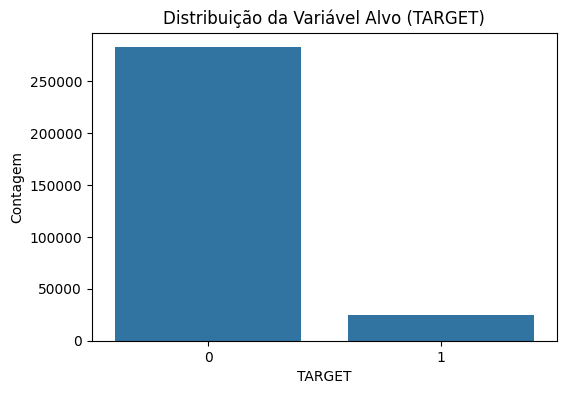

Propor√ß√£o de cr√©ditos aprovados: 8.07%
Propor√ß√£o de cr√©ditos n√£o aprovados: 91.93%


In [60]:
# Gr√°fico da distribui√ß√£o da vari√°vel TARGET
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=df_final)
plt.title('Distribui√ß√£o da Vari√°vel Alvo (TARGET)')
plt.xlabel('TARGET')
plt.ylabel('Contagem')
plt.show()

# Contagem de casos de aprova√ß√£o e reprova√ß√£o
count_approved = df_final[df_final['TARGET'] == 1].shape[0]
count_not_approved = df_final[df_final['TARGET'] == 0].shape[0]

# Total de registros
total_records = df_final.shape[0]

# Propor√ß√£o de aprova√ß√£o e reprova√ß√£o
proportion_approved = count_approved / total_records
proportion_not_approved = count_not_approved / total_records

print(f"Propor√ß√£o de cr√©ditos aprovados: {proportion_approved:.2%}")
print(f"Propor√ß√£o de cr√©ditos n√£o aprovados: {proportion_not_approved:.2%}")

In [61]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 116 entries, SK_ID_CURR to QTD_PARCELAS
dtypes: float64(90), int64(15), object(11)
memory usage: 272.2+ MB


In [62]:
df_final.drop(columns=["SK_ID_CURR"], inplace=True)

In [63]:
# # Calcula correla√ß√£o entre vari√°veis num√©ricas e a vari√°vel TARGET do df_train_clean_final
# corr = df_final.corr(method='spearman', numeric_only=True)

# # M√°scara para o tri√¢ngulo superior
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Configura√ß√£o do gr√°fico
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
# plt.title("Matriz de Correla√ß√£o com a Vari√°vel Alvo (TARGET)")
# plt.show()

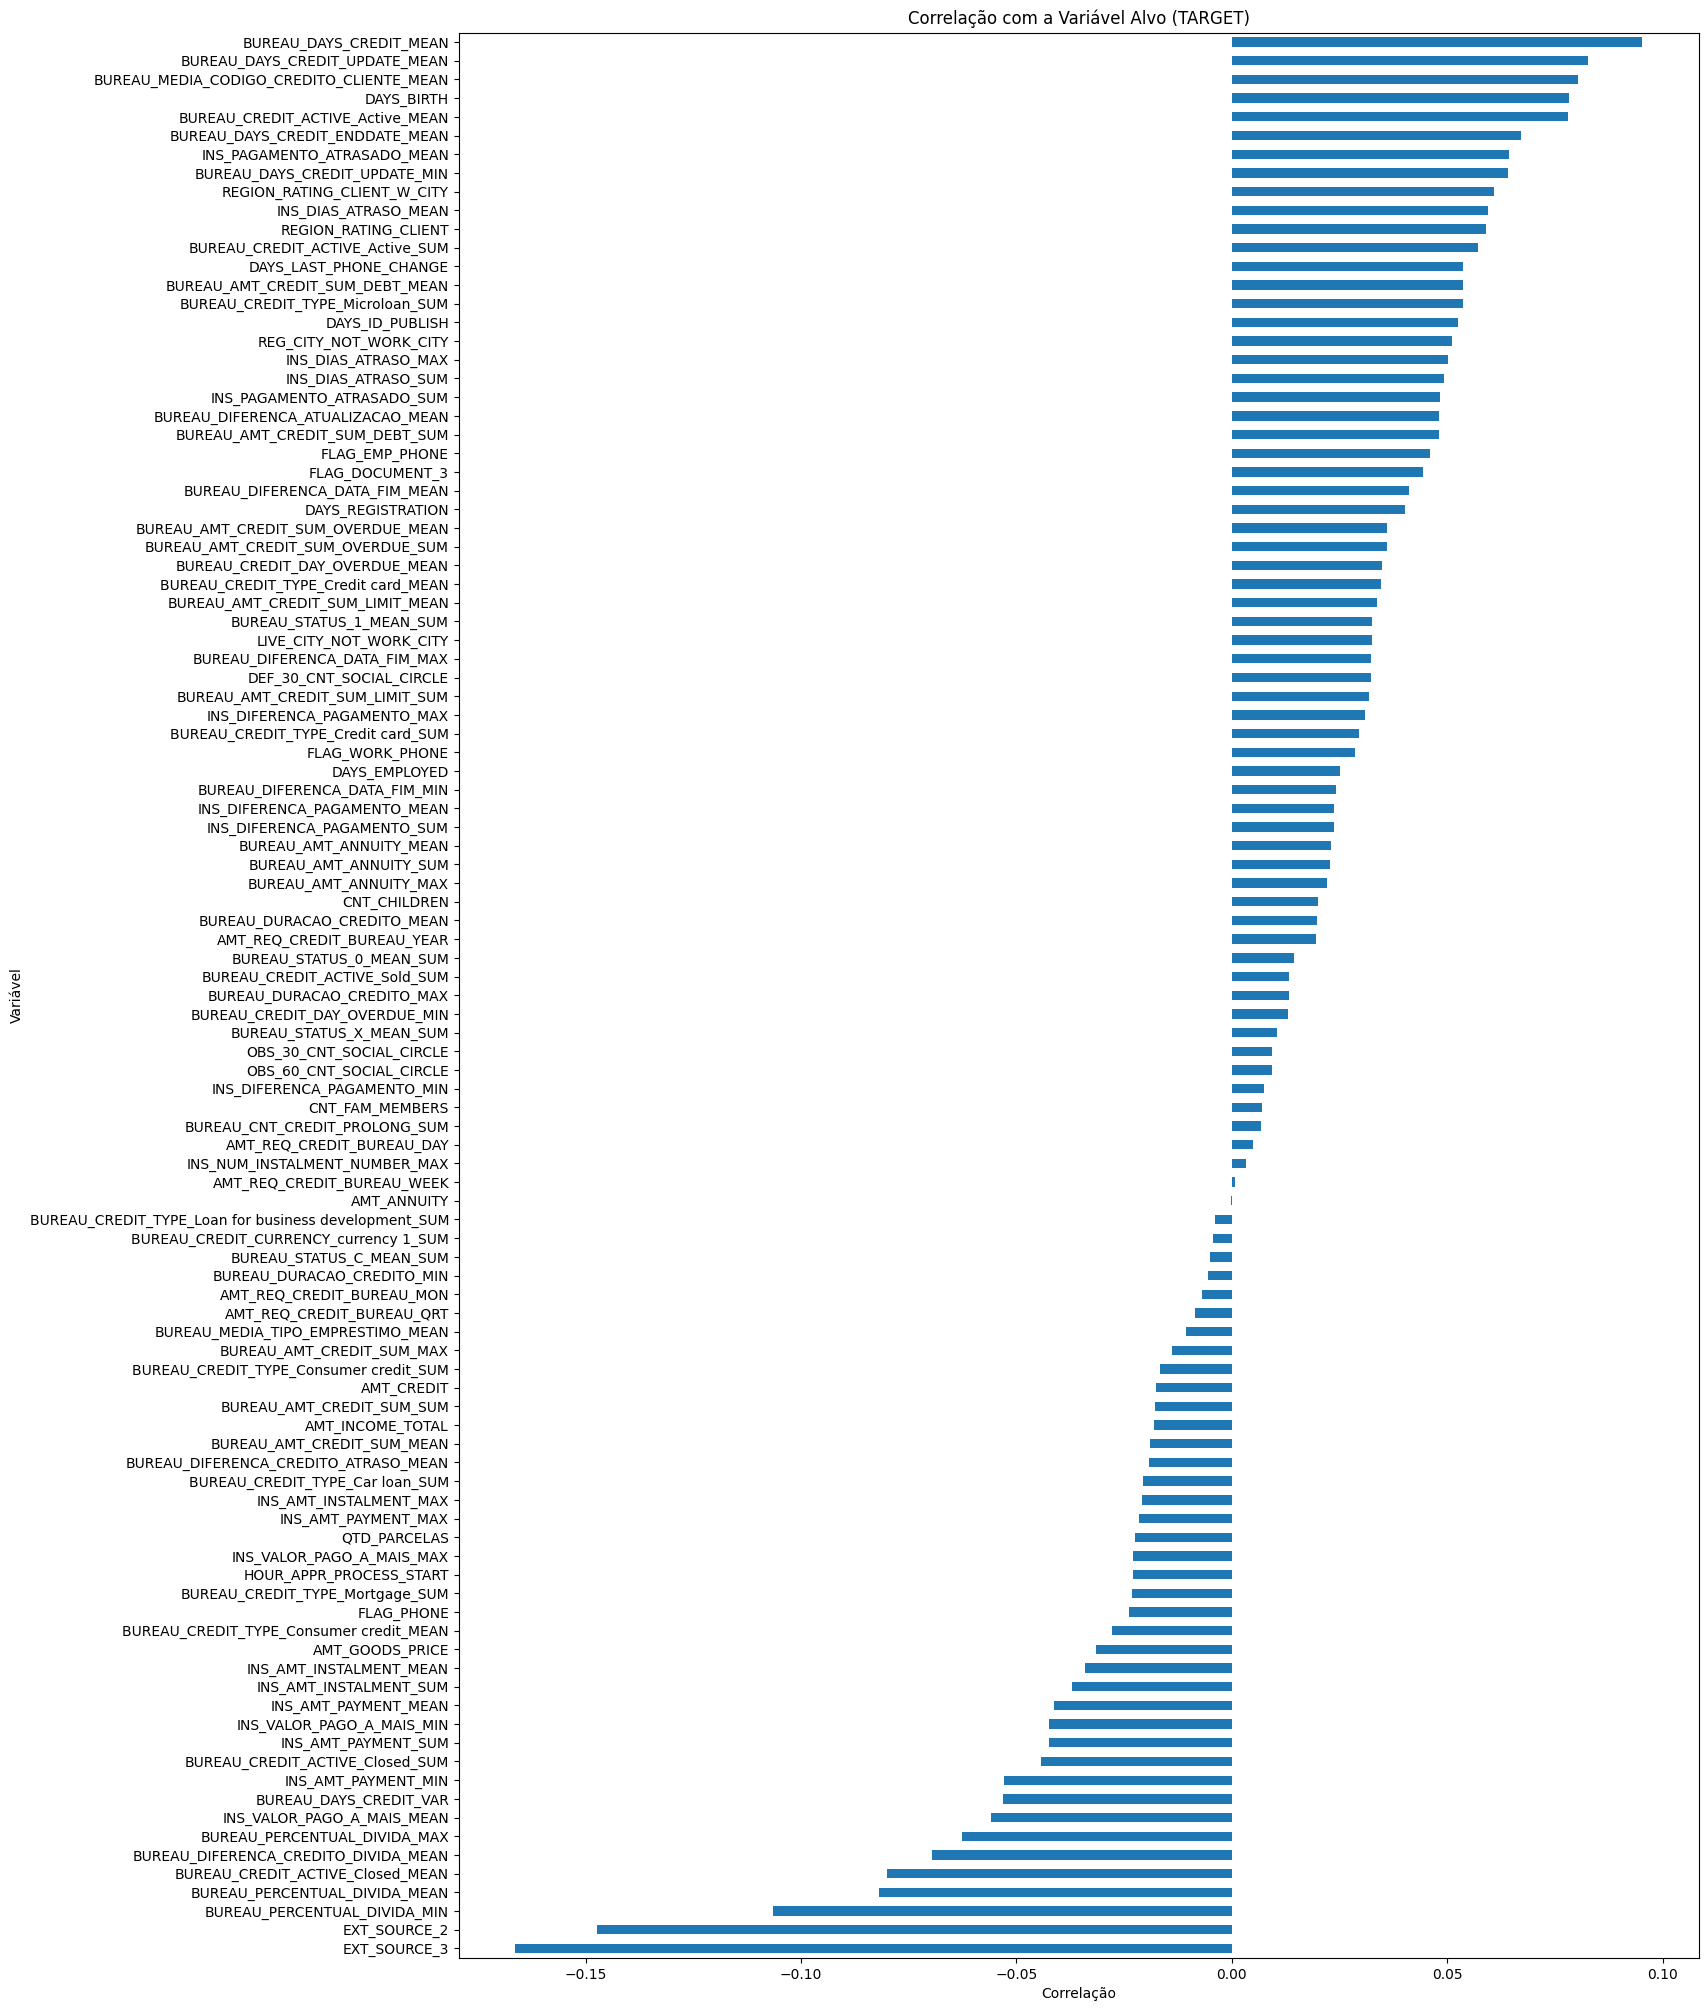

In [64]:
# Correla√ß√£o entre vari√°veis num√©ricas e a vari√°vel TARGET
correlations = df_final.corr(method='spearman', numeric_only=True)['TARGET'].sort_values()
plt.figure(figsize=(16, 25))
correlations.drop('TARGET').plot(kind='barh')
plt.title('Correla√ß√£o com a Vari√°vel Alvo (TARGET)')
plt.xlabel('Correla√ß√£o')
plt.ylabel('Vari√°vel')
plt.show()

In [65]:
low_corr_features = correlations[correlations.abs() < 0.025].index
df_final = df_final.drop(columns=low_corr_features)

# Modelagem

In [66]:
df_modelagem = df_final.copy()

In [67]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)  # Substitui caracteres especiais por "_"
    df.columns = df.columns.str.replace(r'\s+', '_', regex=True)  # Remove espa√ßos em branco
    df.columns = df.columns.str.strip('_')  # Remove "_" do come√ßo e do fim dos nomes
    df.columns = df.columns.str.lower()  # Converte para min√∫sculas para padroniza√ß√£o
    return df

df_modelagem = clean_column_names(df_modelagem)

In [68]:
# Identificar colunas bin√°rias
def identify_binary_columns(df):
    """Identifica colunas bin√°rias no dataframe"""
    binary_cols = []
    for col in df.columns:
        unique_values = df[col].dropna().unique()  # Remove NaN antes de contar
        if len(unique_values) == 2:  # Se tiver apenas dois valores distintos
            binary_cols.append(col)
    return binary_cols

# Aplicar a fun√ß√£o nos dados de treino
binary_features = identify_binary_columns(df_modelagem)

# Converter colunas bin√°rias de string para 0 e 1
binary_mapping = {
    'Y': 1, 'N': 0,
}

for col in binary_features:
    if df_modelagem[col].dtype == 'object':  # Se for string
        df_modelagem[col] = df_modelagem[col].map(binary_mapping).astype(int)

In [69]:
X, y = df_modelagem.drop(columns='target'), df_modelagem['target']

# Dividindo os dados mantendo o desbalanceamento original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((215257, 69), (92254, 69), 215257, 92254)

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215257 entries, 159703 to 301908
Data columns (total 69 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   code_gender                               215257 non-null  object 
 1   flag_own_car                              215257 non-null  int32  
 2   flag_own_realty                           215257 non-null  int32  
 3   amt_goods_price                           215070 non-null  float64
 4   name_type_suite                           214356 non-null  object 
 5   name_income_type                          215257 non-null  object 
 6   name_education_type                       215257 non-null  object 
 7   name_family_status                        215257 non-null  object 
 8   name_housing_type                         215257 non-null  object 
 9   days_birth                                215257 non-null  int64  
 10  days_employed       

In [71]:
# Identificando as colunas por tipo de dado
cat_features = X_train.select_dtypes(include=['object']).columns
num_features = X_train.select_dtypes(include=['float64', 'int64']).columns
ord_features = ["region_rating_client", "region_rating_client_w_city"]
bin_features = [col for col in binary_features if col != "target"]

num_features = [col for col in num_features if col not in bin_features]

In [ ]:
# Criando as transforma√ß√µes para cada tipo de dado

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),      # Preenchimento de valores ausentes com a m√©dia
    ('scaler', MinMaxScaler())                        # Normaliza√ß√£o
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),                       # Preenchimento com valor mais frequente
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))     # One-hot encoding
])

ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),                    # Preenchimento com valor mais frequente
    ('ordinal', OrdinalEncoder(handle_unknown='ignore', unknown_value=-1))   # Encoding ordinal
])

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preenchimento de valores ausentes
])

# Criando o fluxo pr√©-processador com ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('ord', ordinal_transformer, ord_features),
    ('binary', binary_transformer, bin_features)
])

In [73]:
# Criando pipeline para cada modelo (pr√©-processamento + modelo)
def create_pipeline(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Pr√©-processamento
        ('model', model)                 # Modelo de Machine Learning
    ])
    return pipeline

In [74]:
# Ajustando pesos das classes para modelos que aceitam class_weight
classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

# Ajustando scale_pos_weight para XGBoost
contagens = np.bincount(y)
scale_pos_weight = contagens[0] / contagens[1]

In [75]:
# Modelos (os 4 cavaleiros do apocalipse)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=int(scale_pos_weight), random_state=42),
    "lightgbm": LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1, n_jobs=-1),
    "CatBoost": CatBoostClassifier(iterations=100, class_weights=class_weight_dict, random_state=42, verbose=0)
}


Avaliando Modelo: Random Forest
  - Accuracy: 0.9194
  - Precision: 0.7273
  - Recall: 0.0032
  - F1 Score: 0.0064


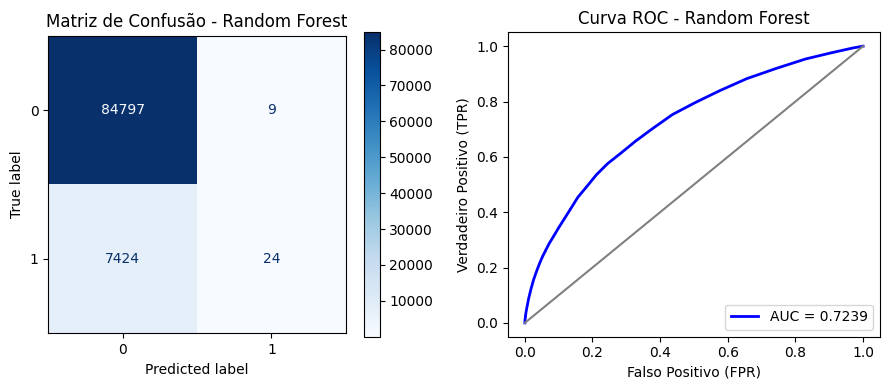


Avaliando Modelo: XGBoost
  - Accuracy: 0.7532
  - Precision: 0.1825
  - Recall: 0.5914
  - F1 Score: 0.2790


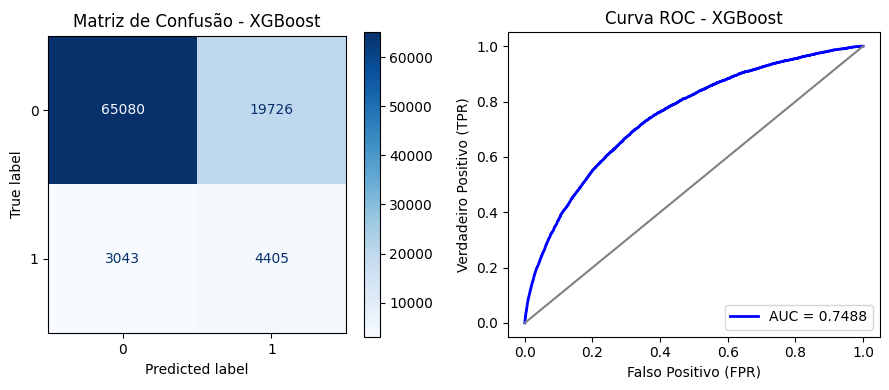


Avaliando Modelo: lightgbm
  - Accuracy: 0.7143
  - Precision: 0.1744
  - Recall: 0.6800
  - F1 Score: 0.2776


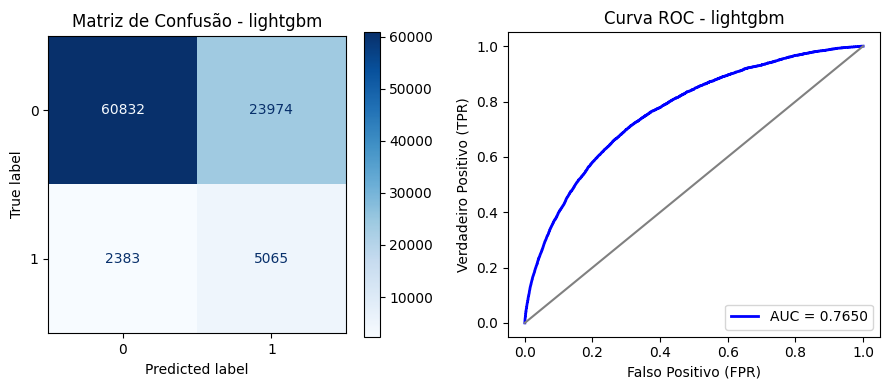


Avaliando Modelo: CatBoost
  - Accuracy: 0.7203
  - Precision: 0.1721
  - Recall: 0.6466
  - F1 Score: 0.2718


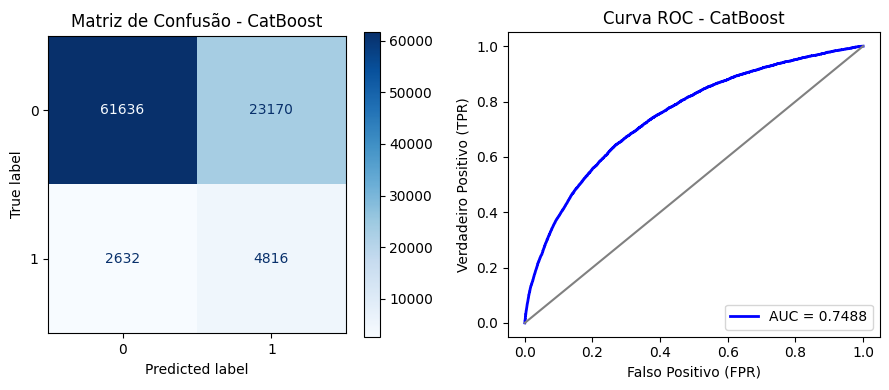

In [77]:
# Treinar e avaliar os modelos
for name, model in models.items():
    print(f"\nAvaliando Modelo: {name}")
    
    # Criar pipeline
    pipeline = create_pipeline(model)

    # Treinar o modelo
    pipeline.fit(X_train, y_train)
    
    # Fazer previs√µes no conjunto de teste
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

    # M√©tricas de avalia√ß√£o
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Precision: {prec:.4f}")
    print(f"  - Recall: {rec:.4f}")
    print(f"  - F1 Score: {f1:.4f}")
    
    # Criar figura com 2 subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    
    # Plotar Matriz de Confus√£o no primeiro subplot
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], cmap='Blues', values_format='d')
    axs[0].set_title(f"Matriz de Confus√£o - {name}")
    
    # Plotar Curva ROC AUC no segundo subplot
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
    axs[1].plot([0, 1], [0, 1], color='gray')
    axs[1].set_xlabel("Falso Positivo (FPR)")
    axs[1].set_ylabel("Verdadeiro Positivo (TPR)")
    axs[1].set_title(f"Curva ROC - {name}")
    axs[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

## Tuning do Modelo - lightgbm

In [78]:
# Aplicando o pipeline nos dados antes de passar para o Optuna
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [79]:
feature_names = preprocessor.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

X_train_transformed_df.head()

num__amt_goods_price  num__days_birth  num__days_employed  \
0              0.438833         0.662578            0.043244   
1              0.103255         0.436869            0.042774   
2              0.012346         0.778399            0.044380   
3              0.001122         0.539168            0.031887   
4              0.057239         0.301706            0.042808   

   num__days_registration  num__days_id_publish  num__region_rating_client  \
0                0.697633              0.746700                        1.0   
1                0.835684              0.848548                        0.5   
2                0.774887              0.426150                        0.5   
3                0.785790              0.264972                        0.5   
4                0.996514              0.578574                        0.5   

   num__region_rating_client_w_city  num__ext_source_2  num__ext_source_3  \
0                               1.0           0.383303           0.717489   
1                               0.5           0.722609           0.490831   
2                               0.5           0.757593           0.569890   
3                               0.5           0.703862           0.500775   
4                               0.5           0.768013           0.802879   

   num__def_30_cnt_social_circle  num__days_last_phone_change  \
0                       0.000000                     0.494641   
1                       0.029412                     0.846459   
2                       0.000000                     0.959925   
3                       0.000000                     0.632805   
4                       0.000000                     0.854613   

   num__bureau_amt_credit_sum_debt_mean  num__bureau_amt_credit_sum_debt_sum  \
0                              0.030882                             0.012748   
1                              0.027283                             0.011122   
2                              0.027283                             0.011122   
3                              0.025473                             0.010047   
4                              0.024432                             0.009302   

   num__bureau_amt_credit_sum_overdue_mean  \
0                                 0.000000   
1                                 0.000037   
2                                 0.000037   
3                                 0.000000   
4                                 0.000000   

   num__bureau_amt_credit_sum_overdue_sum  num__bureau_days_credit_mean  \
0                                0.000000                      0.710702   
1                                0.000066                      0.629733   
2                                0.000066                      0.629733   
3                                0.000000                      0.751370   
4                                0.000000                      0.437671   

   num__bureau_days_credit_var  num__bureau_days_credit_update_mean  \
0                     0.057685                             0.986544   
1                     0.118288                             0.973882   
2                     0.118288                             0.973882   
3                     0.038265                             0.988462   
4                     0.268859                             0.948406   

   num__bureau_days_credit_update_min  num__bureau_credit_day_overdue_mean  \
0                            0.982335                             0.000000   
1                            0.971800                             0.000374   
2                            0.971800                             0.000374   
3                            0.984671                             0.000000   
4                            0.940520                             0.000000   

   num__bureau_days_credit_enddate_mean  \
0                              0.573755   
1                              0.581147   
2                              0.581147   
3                 

In [80]:
X_train_transformed_df.shape

(215257, 180)

In [81]:
# Fun√ß√£o objetivo para o Optuna (Maximizar F1-score)
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),          # N√∫mero de √°rvores no modelo (100 a 1000, com passo de 50)
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),     # Taxa de aprendizado (0.01 a 0.3)
        "max_depth": trial.suggest_int("max_depth", 3, 15),                             # Profundidade m√°xima da √°rvore (3 a 15)
        "num_leaves": trial.suggest_int("num_leaves", 20, 200, step=10),                # N√∫mero de folhas da √°rvore (20 a 200)
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100, step=5),    # M√≠nimo de amostras por folha (5 a 100)
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),                        # Percentual de amostras usadas por √°rvore (0.5 a 1.0)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),          # Percentual de colunas usadas por √°rvore (0.5 a 1.0)
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),            # Regulariza√ß√£o L1 (1e-8 a 10.0)
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)           # Regulariza√ß√£o L2 (1e-8 a 10.0)
    }

    model = LGBMClassifier(**params, random_state=42, class_weight='balanced', n_jobs=-1)   # Criando o modelo LightGBM
    model.fit(X_train_transformed, y_train)                                                 # Treinando o modelo
    y_pred = model.predict(X_test_transformed)                                              # Fazendo previs√µes
    f1 = f1_score(y_test, y_pred)                                                           # Calculando o F1-score (quanto maior, melhor)

    return f1

In [82]:
# Criando o estudo do Optuna para maximizar o F1-score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-03-09 17:23:28,620] A new study created in memory with name: no-name-9b387081-666f-43f1-a4ba-374568d05063


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-09 17:23:32,332] Trial 0 finished with value: 0.29019445593711213 and parameters: {'n_estimators': 350, 'learning_rate': 0.22471185003936378, 'max_depth': 7, 'num_leaves': 130, 'min_child_samples': 100, 'subsample': 0.7918604511650313, 'colsample_bytree': 0.965941992583291, 'reg_alpha': 2.1566416853179966e-06, 'reg_lambda': 1.2574433180920939}. Best is trial 0 with value: 0.29019445593711213.
[I 2025-03-09 17:23:39,261] Trial 1 finished with value: 0.2797090627506292 and parameters: {'n_estimators': 500, 'learning_rate': 0.011989674661322516, 'max_depth': 14, 'num_leaves': 60, 'min_child_samples': 30, 'subsample': 0.5104734667957116, 'colsample_bytree': 0.8018051521753007, 'reg_alpha': 0.04503852983553535, 'reg_lambda': 3.691966932186285e-05}. Best is trial 0 with value: 0.29019445593711213.
[I 2025-03-09 17:23:48,722] Trial 2 finished with value: 0.26045355700528117 and parameters: {'n_estimators': 900, 'learning_rate': 0.14434670123026805, 'max_depth': 11, 'num_leaves': 80

In [83]:
# Exibir melhores hiperpar√¢metros encontrados
print("Melhores par√¢metros encontrados:", study.best_params)

Melhores par√¢metros encontrados: {'n_estimators': 800, 'learning_rate': 0.03505773850274863, 'max_depth': 13, 'num_leaves': 170, 'min_child_samples': 50, 'subsample': 0.6345458717481246, 'colsample_bytree': 0.5108998531317953, 'reg_alpha': 2.2560515410966855, 'reg_lambda': 0.15651151420523085}


In [84]:
best_params = study.best_params # Pegando os melhores hiperpar√¢metros encontrados

# Criando o modelo otimizado
best_model = LGBMClassifier(**best_params, random_state=42, class_weight='balanced', n_jobs=-1)
best_model.fit(X_train_transformed, y_train)

# Fazendo previs√µes no conjunto de teste
y_pred = best_model.predict(X_test_transformed)
y_prob = best_model.predict_proba(X_test_transformed)[:, 1]  # Probabilidade da classe positiva

In [85]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nResultados do Modelo Ajustado")
print(f"  - Accuracy: {acc:.4f}")
print(f"  - Precision: {prec:.4f}")
print(f"  - Recall: {rec:.4f}")
print(f"  - F1 Score: {f1:.4f}")


Resultados do Modelo Ajustado
  - Accuracy: 0.8340
  - Precision: 0.2333
  - Recall: 0.4621
  - F1 Score: 0.3101


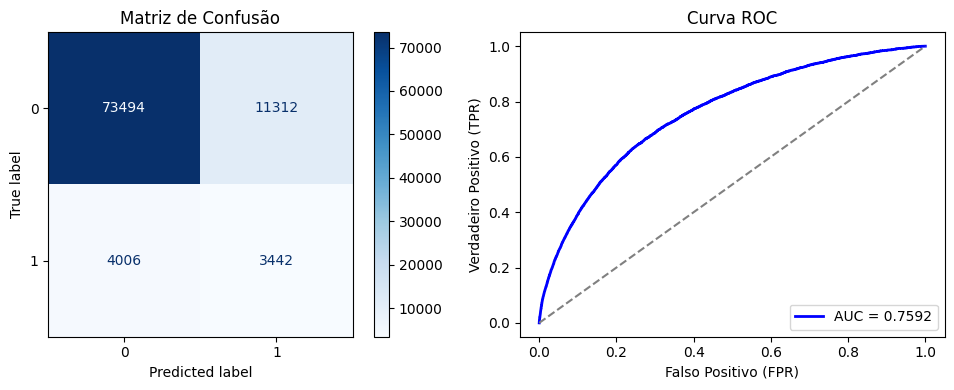

In [86]:
# Criar figura com 2 subplots para Matriz de Confus√£o e Curva ROC
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de Confus√£o
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs[0], cmap='Blues', values_format='d')
axs[0].set_title("Matriz de Confus√£o")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
axs[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1].set_xlabel("Falso Positivo (FPR)")
axs[1].set_ylabel("Verdadeiro Positivo (TPR)")
axs[1].set_title("Curva ROC")
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## Calibrando Modelo

> üî• O que √© Calibra√ß√£o de Probabilidades?

Calibra√ß√£o significa **ajustar as probabilidades do modelo para que reflitam a realidade**.

Um modelo de machine learning de classifica√ß√£o **retorna probabilidades** ao prever um resultado. Por exemplo:

‚û°Ô∏è **Sem calibra√ß√£o:**  
O modelo prev√™ que **um cliente tem 90% de chance de n√£o pagar um empr√©stimo**, mas na pr√°tica, apenas **60% dos clientes com essa previs√£o realmente n√£o pagam**.  
Ou seja, o modelo **superestimou a confian√ßa** da previs√£o.

‚û°Ô∏è **Com calibra√ß√£o:**  
Ap√≥s a calibra√ß√£o, se o modelo prev√™ **90% de chance**, ent√£o **realmente 90% das pessoas nessa faixa n√£o pagam**.

**A calibra√ß√£o corrige esse erro e torna as previs√µes mais confi√°veis!** ‚úÖ

---

> üéØ Exemplo Simples: Apostando no Clima

Imagine que voc√™ tem um **modelo que prev√™ a chance de chover amanh√£**:

- Ele diz que **vai chover com 80% de probabilidade**.
- Mas, olhando **100 dias com essa previs√£o**, s√≥ choveu **60 vezes**.

Isso significa que o modelo **superestima a probabilidade** de chuva.  
A calibra√ß√£o ajustaria esse valor de **80% para 60%**, tornando-o **mais realista**.

---

> üîé Como Funciona a Calibra√ß√£o?

A calibra√ß√£o compara **as previs√µes do modelo** com **o que realmente aconteceu** e ajusta as probabilidades.

> **1Ô∏è‚É£ Sem Calibra√ß√£o (Modelo mal ajustado)**

| Probabilidade Prevista | Frequ√™ncia Real |
|------------------------|----------------|
| 90% de chance de n√£o pagar | 60% realmente n√£o pagaram |
| 50% de chance de n√£o pagar | 50% realmente n√£o pagaram |
| 20% de chance de n√£o pagar | 30% realmente n√£o pagaram |

üî¥ **O modelo est√° confiante demais!** Ele prev√™ **90%**, mas s√≥ **60% realmente n√£o pagam**.

---

> **2Ô∏è‚É£ Com Calibra√ß√£o (Modelo Ajustado)**

Ap√≥s a calibra√ß√£o, os valores ficam mais realistas:

| Probabilidade Ajustada | Frequ√™ncia Real |
|------------------------|----------------|
| 60% de chance de n√£o pagar | 60% realmente n√£o pagaram |
| 50% de chance de n√£o pagar | 50% realmente n√£o pagaram |
| 30% de chance de n√£o pagar | 30% realmente n√£o pagaram |

‚úÖ **Agora as previs√µes refletem melhor a realidade**.

---

> ‚öôÔ∏è Como Calibramos um Modelo no `sklearn`?

Podemos usar `CalibratedClassifierCV` no **scikit-learn**, que ajusta as probabilidades do modelo automaticamente.

> **M√©todos de Calibra√ß√£o**

1. **Platt Scaling (`method="sigmoid"`)**  
   - Usa uma **fun√ß√£o sigmoide** para ajustar as probabilidades.  
   - Funciona bem quando o modelo j√° tem **boa separa√ß√£o entre classes**.  
   - Melhor para **dados menos desbalanceados**.  

2. **Isotonic Regression (`method="isotonic"`)**  
   - Usa **regress√£o isot√¥nica**, que ajusta as probabilidades sem for√ßar uma forma espec√≠fica.  
   - Funciona melhor quando as previs√µes est√£o **muito erradas**.  
   - Precisa de **mais dados de calibra√ß√£o** para funcionar bem.

---

üéØ Quando usar a calibra√ß√£o?  
‚úÖ Quando as probabilidades previstas pelo modelo n√£o refletem bem a realidade.  
‚úÖ Quando precisamos interpretar diretamente as probabilidades (exemplo: aprovar um empr√©stimo se a chance de inadimpl√™ncia for maior que 70%).  
‚úÖ Quando usamos modelos como Random Forest, Gradient Boosting (LightGBM, XGBoost), que podem ser mal calibrados.  

In [87]:
# Pegando os melhores hiperpar√¢metros encontrados no Optuna
best_params = study.best_params

# Criando e treinando o modelo final sem calibra√ß√£o
best_model = LGBMClassifier(**best_params, random_state=42, class_weight='balanced', n_jobs=-1)
best_model.fit(X_train_transformed, y_train)

# Criando um modelo calibrado (Platt Scaling ou Isotonic)
calibrated_model = CalibratedClassifierCV(best_model, method="sigmoid", cv=5, n_jobs=-1)

# Treinar o modelo calibrado
calibrated_model.fit(X_train_transformed, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(class_weight='balanced',
                                                colsample_bytree=0.5108998531317953,
                                                learning_rate=0.03505773850274863,
                                                max_depth=13,
                                                min_child_samples=50,
                                                n_estimators=800, n_jobs=-1,
                                                num_leaves=170, random_state=42,
                                                reg_alpha=2.2560515410966855,
                                                reg_lambda=0.15651151420523085,
                                                subsample=0.6345458717481246),
                       n_jobs=-1)

In [88]:
# Previs√µes antes e depois da calibra√ß√£o
y_pred_before = best_model.predict(X_test_transformed)
y_prob_before = best_model.predict_proba(X_test_transformed)[:, 1]

y_pred_after = calibrated_model.predict(X_test_transformed)
y_prob_after = calibrated_model.predict_proba(X_test_transformed)[:, 1]

In [89]:
# Calculando m√©tricas antes e depois da calibra√ß√£o

metrics_before = {
    "AUC-ROC": roc_auc_score(y_test, y_prob_before),
    "Accuracy": accuracy_score(y_test, y_pred_before),
    "Precision": precision_score(y_test, y_pred_before, zero_division=0),
    "Recall": recall_score(y_test, y_pred_before, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_before, zero_division=0)
}

metrics_after = {
    "AUC-ROC": roc_auc_score(y_test, y_prob_after),
    "Accuracy": accuracy_score(y_test, y_pred_after),
    "Precision": precision_score(y_test, y_pred_after, zero_division=0),
    "Recall": recall_score(y_test, y_pred_after, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_after, zero_division=0)
}

# Compara√ß√£o das m√©tricas antes e depois
print("\nCompara√ß√£o das M√©tricas Antes e Depois da Calibra√ß√£o")
for metric in metrics_before.keys():
    print(f"{metric}: Antes = {metrics_before[metric]:.4f} | Depois = {metrics_after[metric]:.4f}")


Compara√ß√£o das M√©tricas Antes e Depois da Calibra√ß√£o
AUC-ROC: Antes = 0.7592 | Depois = 0.7632
Accuracy: Antes = 0.8340 | Depois = 0.9194
Precision: Antes = 0.2333 | Depois = 0.7895
Recall: Antes = 0.4621 | Depois = 0.0020
F1 Score: Antes = 0.3101 | Depois = 0.0040


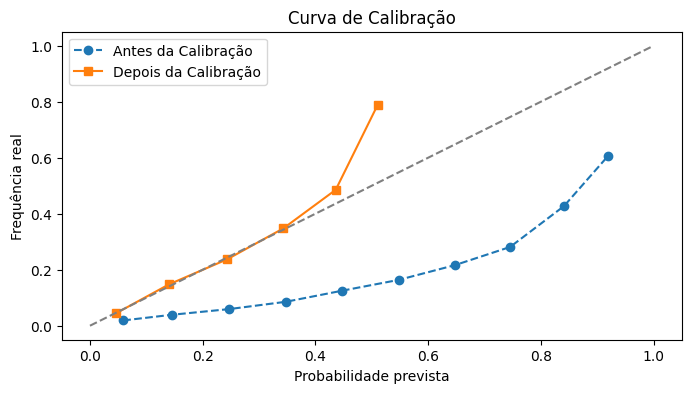

In [90]:
# Criando a Curva de Calibra√ß√£o
plt.figure(figsize=(8, 4))
prob_true_before, prob_pred_before = calibration_curve(y_test, y_prob_before, n_bins=10)
prob_true_after, prob_pred_after = calibration_curve(y_test, y_prob_after, n_bins=10)

# Plotando
plt.plot(prob_pred_before, prob_true_before, marker="o", label="Antes da Calibra√ß√£o", linestyle="dashed")
plt.plot(prob_pred_after, prob_true_after, marker="s", label="Depois da Calibra√ß√£o", linestyle="solid")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha de refer√™ncia perfeita
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequ√™ncia real")
plt.title("Curva de Calibra√ß√£o")
plt.legend()
plt.show()

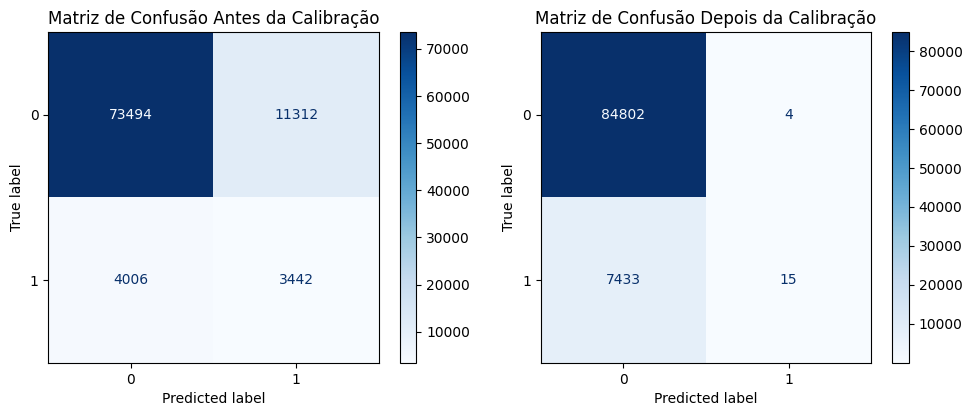

In [91]:
# Criando a Matriz de Confus√£o antes e depois
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de Confus√£o antes da calibra√ß√£o
cm_before = confusion_matrix(y_test, y_pred_before)
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot(ax=axs[0], cmap='Blues', values_format='d')
axs[0].set_title("Matriz de Confus√£o Antes da Calibra√ß√£o")

# Matriz de Confus√£o depois da calibra√ß√£o
cm_after = confusion_matrix(y_test, y_pred_after)
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot(ax=axs[1], cmap='Blues', values_format='d')
axs[1].set_title("Matriz de Confus√£o Depois da Calibra√ß√£o")

plt.tight_layout()
plt.show()

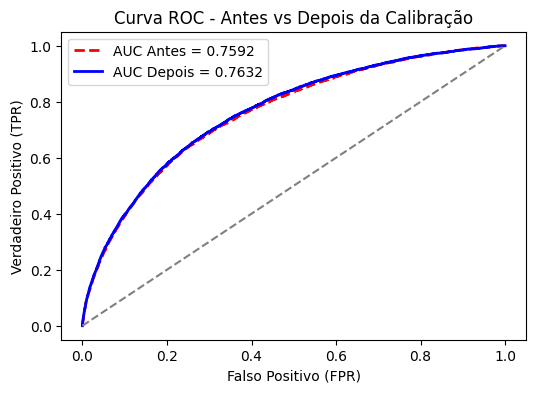

In [92]:
# Compara√ß√£o da Curva ROC antes e depois
fpr_before, tpr_before, _ = roc_curve(y_test, y_prob_before)
fpr_after, tpr_after, _ = roc_curve(y_test, y_prob_after)

plt.figure(figsize=(6, 4))
plt.plot(fpr_before, tpr_before, color='red', lw=2, linestyle="dashed", label=f'AUC Antes = {metrics_before["AUC-ROC"]:.4f}')
plt.plot(fpr_after, tpr_after, color='blue', lw=2, label=f'AUC Depois = {metrics_after["AUC-ROC"]:.4f}')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha de refer√™ncia
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curva ROC - Antes vs Depois da Calibra√ß√£o")
plt.legend()
plt.show()

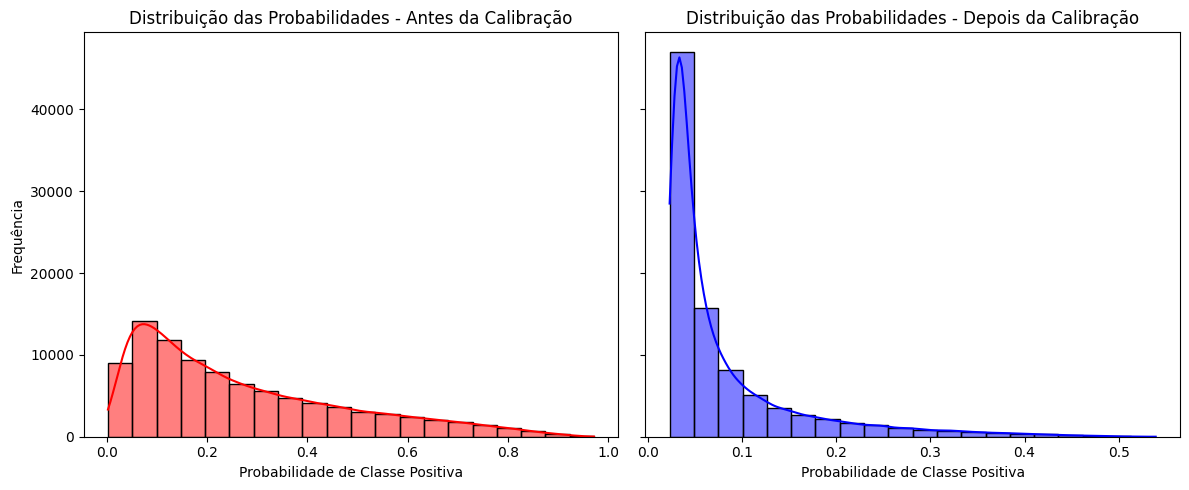

In [93]:
# Criando a figura com 2 subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plotando o histograma das probabilidades antes da calibra√ß√£o
sns.histplot(y_prob_before, bins=20, kde=True, color='red', ax=axs[0])
axs[0].set_title("Distribui√ß√£o das Probabilidades - Antes da Calibra√ß√£o")
axs[0].set_xlabel("Probabilidade de Classe Positiva")
axs[0].set_ylabel("Frequ√™ncia")

# Plotando o histograma das probabilidades depois da calibra√ß√£o
sns.histplot(y_prob_after, bins=20, kde=True, color='blue', ax=axs[1])
axs[1].set_title("Distribui√ß√£o das Probabilidades - Depois da Calibra√ß√£o")
axs[1].set_xlabel("Probabilidade de Classe Positiva")

plt.tight_layout()
plt.show()


M√©tricas para Limiar = 0.5
Accuracy: 0.9194
Precision: 0.7895
Recall: 0.0020
F1 Score: 0.0040

Matriz de Confus√£o para Limiar = 0.5


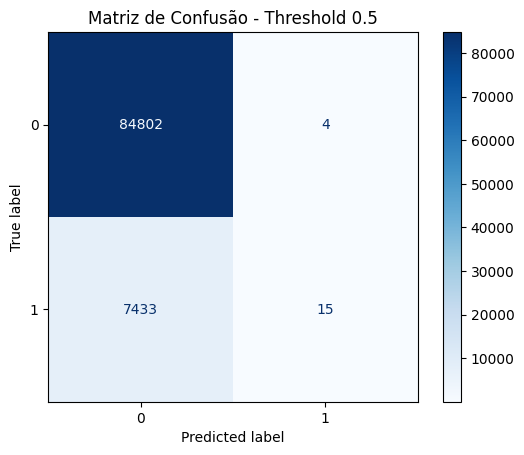


M√©tricas para Limiar = 0.4
Accuracy: 0.9192
Precision: 0.4932
Recall: 0.0490
F1 Score: 0.0892

Matriz de Confus√£o para Limiar = 0.4


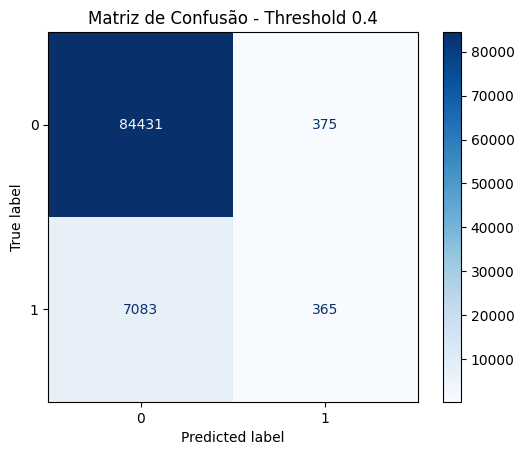


M√©tricas para Limiar = 0.3
Accuracy: 0.9117
Precision: 0.3837
Recall: 0.1537
F1 Score: 0.2195

Matriz de Confus√£o para Limiar = 0.3


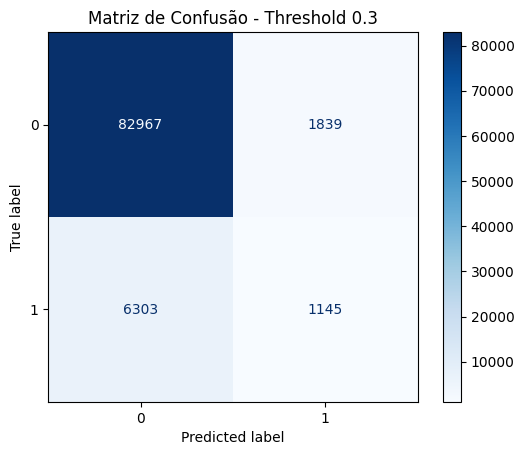


M√©tricas para Limiar = 0.2
Accuracy: 0.8827
Precision: 0.2911
Recall: 0.3157
F1 Score: 0.3029

Matriz de Confus√£o para Limiar = 0.2


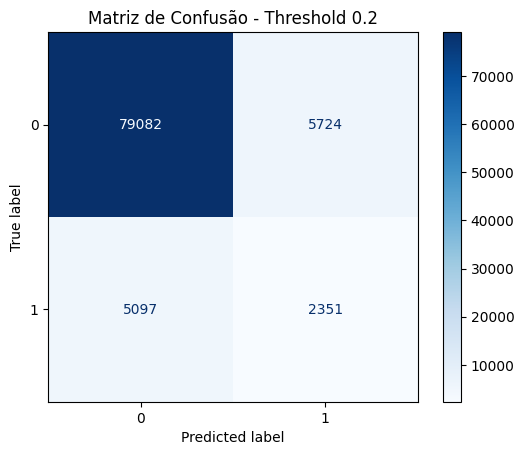

In [94]:
# Testar diferentes limiares
for threshold in [0.5, 0.4, 0.3, 0.2]:
    y_pred_custom = (y_prob_after >= threshold).astype(int)

    # Calcular m√©tricas para o limiar
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred_custom),
        "Precision": precision_score(y_test, y_pred_custom, zero_division=0),
        "Recall": recall_score(y_test, y_pred_custom, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred_custom, zero_division=0)
    }

    # Exibir m√©tricas
    print(f"\nM√©tricas para Limiar = {threshold}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Exibir a Matriz de Confus√£o
    print(f"\nMatriz de Confus√£o para Limiar = {threshold}")
    cm = confusion_matrix(y_test, y_pred_custom)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Matriz de Confus√£o - Threshold {threshold}")
    plt.show()

## Teste Final

In [95]:
df_final_test = pd.read_csv(Path("data", "01_raw", "application_test.csv"))

In [96]:
final_test_merged = df_final_test.merge(bureau_balance_final, on='SK_ID_CURR', how='left')
final_test_merged = final_test_merged.merge(installments_clean, on='SK_ID_CURR', how='left')

In [97]:
final_test_merged.shape

(48744, 243)

In [98]:
final_test_merged = clean_column_names(final_test_merged)

for col in bin_features:
    if final_test_merged[col].dtype == 'object':  # Se for string
        final_test_merged[col] = final_test_merged[col].map(binary_mapping).astype(int)

final_test_merged.head()

sk_id_curr name_contract_type code_gender  flag_own_car  flag_own_realty  \
0      100001         Cash loans           F             0                1   
1      100005         Cash loans           M             0                1   
2      100013         Cash loans           M             1                1   
3      100028         Cash loans           F             0                1   
4      100038         Cash loans           M             1                0   

   cnt_children  amt_income_total  amt_credit  amt_annuity  amt_goods_price  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  name_type_suite name_income_type            name_education_type  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  name_family_status  name_housing_type  region_population_relative  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   days_birth  days_employed  days_registration  days_id_publish  own_car_age  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   flag_mobil  flag_emp_phone  flag_work_phone  flag_cont_mobile  flag_phone  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   flag_email     occupation_type  cnt_fam_members  region_rating_client  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   region_rating_client_w_city weekday_appr_process_start  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   hour_appr_process_start  reg_region_not_live_region  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   reg_region_not_work_region  live_region_not_work_region  \
0       

In [99]:
X_final_test_transformed = preprocessor.transform(final_test_merged)

In [100]:
feature_names = preprocessor.get_feature_names_out()
X_final_test_transformed_df = pd.DataFrame(X_final_test_transformed, columns=feature_names)

X_final_test_transformed_df.head()

num__amt_goods_price  num__days_birth  num__days_employed  \
0              0.102132         0.339990            0.039846   
1              0.034792         0.407143            0.034256   
2              0.147026         0.294517            0.034285   
3              0.382716         0.640383            0.041055   
4              0.145903         0.693787            0.040206   

   num__days_registration  num__days_id_publish  num__region_rating_client  \
0                0.790451              0.887175                        0.5   
1                0.630431              0.774489                        0.5   
2                0.911843              0.513269                        0.5   
3                0.918936              0.415312                        0.5   
4                0.837873              0.407809                        0.5   

   num__region_rating_client_w_city  num__ext_source_2  num__ext_source_3  \
0                               0.5           0.923573           0.177549   
1                               0.5           0.341118           0.482907   
2                               0.5           0.818464           0.681715   
3                               0.5           0.596114           0.683628   
4                               0.5           0.497880           0.569890   

   num__def_30_cnt_social_circle  num__days_last_phone_change  \
0                            0.0                     0.594595   
1                            0.0                     1.000000   
2                            0.0                     0.800559   
3                            0.0                     0.579450   
4                            0.0                     0.808714   

   num__bureau_amt_credit_sum_debt_mean  num__bureau_amt_credit_sum_debt_sum  \
0                              0.026129                             0.010986   
1                              0.028459                             0.010903   
2                              0.024224                             0.009219   
3                              0.024571                             0.009771   
4                              0.027283                             0.011122   

   num__bureau_amt_credit_sum_overdue_mean  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                 0.000000   
4                                 0.000037   

   num__bureau_amt_credit_sum_overdue_sum  num__bureau_days_credit_mean  \
0                                0.000000                      0.748973   
1                                0.000000                      0.935388   
2                                0.000000                      0.405651   
3                                0.000000                      0.520634   
4                                0.000066                      0.629733   

   num__bureau_days_credit_var  num__bureau_days_credit_update_mean  \
0                     0.057841                             0.995552   
1                     0.006347                             0.997405   
2                     0.037399                             0.962964   
3                     0.103698                             0.968886   
4                     0.118288                             0.973882   

   num__bureau_days_credit_update_min  num__bureau_credit_day_overdue_mean  \
0                            0.996305                             0.000000   
1                            0.997115                             0.000000   
2                            0.968198                             0.000000   
3                            0.962715                             0.000000   
4                            0.971800                             0.000374   

   num__bureau_days_credit_enddate_mean  \
0                              0.574185   
1                              0.579069   
2                              0.558442   
3                 

In [101]:
X_final_test_transformed_df.shape

(48744, 180)

In [102]:
# Fazendo previs√µes no conjunto final de teste
y_pred_final_test = best_model.predict(X_final_test_transformed)
y_prob_final_test = best_model.predict_proba(X_final_test_transformed)[:, 1]

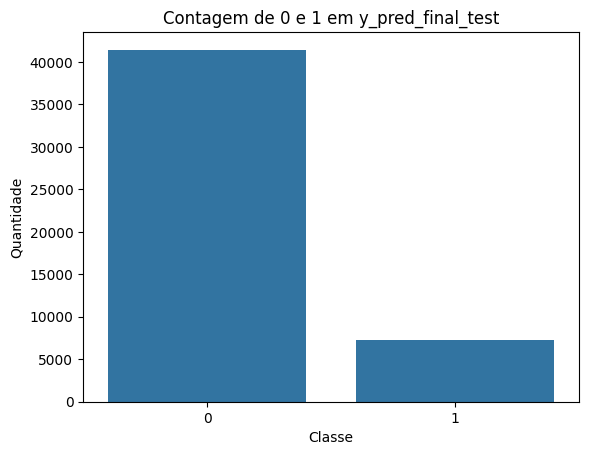

In [103]:
# Plotando a quantidade de 0s e 1s em y_pred_final_test
sns.countplot(x=y_pred_final_test)
plt.title("Contagem de 0 e 1 em y_pred_final_test")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.show()

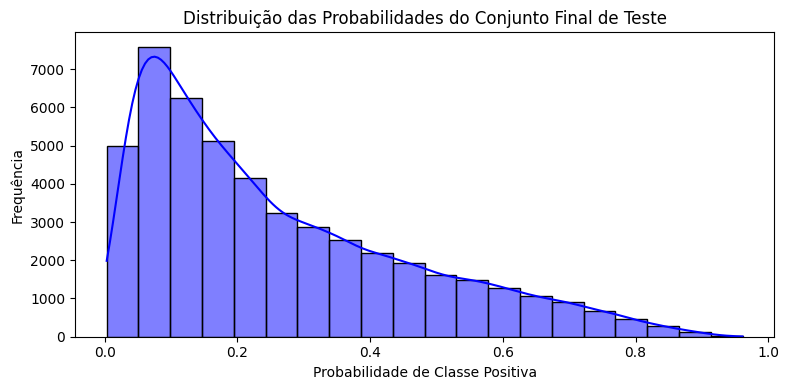

In [104]:
# Plotando a distribui√ß√£o das probabilidades
plt.figure(figsize=(8, 4))
sns.histplot(y_prob_final_test, bins=20, kde=True, color='blue')
plt.title("Distribui√ß√£o das Probabilidades do Conjunto Final de Teste")
plt.xlabel("Probabilidade de Classe Positiva")
plt.ylabel("Frequ√™ncia")
plt.tight_layout()
plt.show()

# that's all folks...